In [2]:
from os import listdir
from os.path import isfile, join
import pandas as pd
import numpy as np
from scipy import stats
import re
import matplotlib.pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages
from myplots import roundup, rounddown, find_decimal_fold, percentile_cut_off, rarefaction_calc, rarefaction_plot
from matplotlib.ticker import FormatStrFormatter
import cPickle as pickle
from Bio.SeqUtils import GC
import seaborn as sns

In [371]:
#extract data:
sample_name='HIP00602'
sample_df=pd.read_table("/net/mraid08/export/genie/Lab/Personal/ShaniBAF/TCR_demo_data/%s.tsv" %sample_name)  
sample_df_prod = sample_df[sample_df['sequenceStatus'] == 'In']
sample_df_non_prod = sample_df[sample_df['sequenceStatus'] != 'In']

# Parameters calculations:

## parameters frequencies to calculate:


V segment selected (V) DONE
D segment selected (D) DONE
J segment selected (J) DONE
(D-J combination) (D,J) DONE

Number of bases deleted from the 3’ end of the V gene (delV) DONE
Number of bases deleted from the 5’ end of the d gene (del5’D) DONE
Number of bases deleted from the 3’ end of the d gene (del3’D) DONE
Number of bases deleted from the 5’ end of the J gene (delJ) DONE


Number of bases deleted from the 3’ end of the V gene given V (delV|V)  DONE
Number of bases deleted from the 5’ end of the d gene given D (del5’D|D) DONE 
Number of bases deleted from the 3’ end of the d gene given D(del3’D|D)  DONE
Number of bases deleted from the 5’ end of the J gene (given J (delJ|J) DONE




the number of palindromic nucleotides at the 3’ end of the V gene (palV)
the number of palindromic nucleotides at the 5’ end of the D gene (pal5’D)
the number of palindromic nucleotides at the 3’ end of the D gene (pal3’D)
the number of palindromic nucleotides at the 5’ end of the J gene (palJ)

The number of random nt inserted at the VD junction (insVD) DONE
The number of random nt inserted at the DJ junction (insDJ) DONE

(x1….xinsVD) the specific sequence of length insVD inserted at the VD junction (read 5-->3 direction from the sense strand)
(y1….yinsDJ) the specific sequence of length insDJ inserted at the DJ junction (read 5-->3 direction from the antisense strand)


In [378]:
# calculate independent frequencies for segment selections, deletions and insertions (results are saved in df pickles):


parList1 = ['vGeneName','jGeneName','dGeneName','cdr3Length', 'vDeletion', 'n1Insertion', 'd5Deletion',
            'd3Deletion', 'n2Insertion', 'jDeletion']

for par in parList1:
    parFreqTable=sample_df_non_prod.groupby(['%s' % par])[['count (reads)']].agg([('n unique', 'count'), ('sum reads', np.sum)])
    if 'unresolved' in parFreqTable.index:
        parFreqTable=parFreqTable.drop('unresolved')
    parFreqTable['weighted uniques']=parFreqTable['count (reads)','n unique']/(parFreqTable['count (reads)','n unique'].sum())
    parFreqTable['weighted reads']=parFreqTable['count (reads)','sum reads']/(parFreqTable['count (reads)','sum reads'].sum())
    with open('/net/mraid08/export/genie/Lab/Personal/ShaniBAF/TCR_demo_data/SuffStat/SuffStatTables/%s_%s' %(sample_name, par),"wb" ) as f:
        pickle.dump(parFreqTable,f)
    f.close()
    print parFreqTable
   


               count (reads)           weighted uniques weighted reads
                    n unique sum reads                                
vGeneName                                                             
TCRBV01-01               309      9430         0.007944       0.006624
TCRBV02-01               717     35298         0.018433       0.024796
TCRBV03-01                11       181         0.000283       0.000127
TCRBV03-02                15       238         0.000386       0.000167
TCRBV04-01               656     28030         0.016865       0.019691
TCRBV04-02               569     17588         0.014628       0.012355
TCRBV04-03              1258     54318         0.032342       0.038157
TCRBV05-01              1660     55473         0.042677       0.038969
TCRBV05-03               632     22317         0.016248       0.015677
TCRBV05-04               683     33246         0.017559       0.023355
TCRBV05-05               337     10690         0.008664       0.007510
TCRBV0

In [372]:
#calculate joint frequencies for D and J segment selection (results are saved in df pickles):

nonProdDJ=sample_df_non_prod[['nucleotide','count (reads)', 'dFamilyName','jGeneName']]
nonProdDJ=nonProdDJ[nonProdDJ['dFamilyName'] !='unresolved']
nonProdDJ=nonProdDJ[nonProdDJ['jGeneName'] !='unresolved']

nonProdDJ['J-D']=nonProdDJ['dFamilyName']+nonProdDJ['jGeneName']
nonProdDJ=nonProdDJ[~nonProdDJ['J-D'].isnull()]
nonProdDJ['J-D'].replace('.*D','D',inplace=True, regex=True)
nonProdDJ['J-D'].replace('TCRBJ','J',inplace=True, regex=True)
nonProdDJ['J-D'].replace('-','',inplace=True, regex=True)

parFreqTable=nonProdDJ.groupby(['J-D'])[['count (reads)']].agg([('n unique', 'count'), ('sum reads', np.sum)])
parFreqTable['weighted uniques']=parFreqTable['count (reads)','n unique']/(parFreqTable['count (reads)','n unique'].sum())
parFreqTable['weighted reads']=parFreqTable['count (reads)','sum reads']/(parFreqTable['count (reads)','sum reads'].sum())
with open('/net/mraid08/export/genie/Lab/Personal/ShaniBAF/TCR_demo_data/SuffStat/SuffStatTables/%s_J-D' %sample_name ,"wb" ) as f:
    pickle.dump(parFreqTable,f)
f.close()
print parFreqTable


         count (reads)           weighted uniques weighted reads
              n unique sum reads                                
J-D                                                             
D01J0101          2113    104081         0.051854       0.072281
D01J0102          2142     97774         0.052566       0.067901
D01J0103           703     30806         0.017252       0.021394
D01J0104           988     50080         0.024246       0.034779
D01J0105          2307     84099         0.056615       0.058404
D01J0106           831     22863         0.020393       0.015878
D01J0201          1281     39208         0.031436       0.027229
D01J0202           935     28151         0.022945       0.019550
D01J0203           923     21923         0.022651       0.015225
D01J0204           416     16215         0.010209       0.011261
D01J0205          1420     27726         0.034847       0.019255
D01J0206           362     10059         0.008884       0.006986
D01J0207          3535   

In [186]:
#calculate dependent frequencies for deletions (dependent on the specific segment chosen):


pars = {'vGeneName':['vDeletion'],'jGeneName':['jDeletion'] ,'dGeneName':['d5Deletion','d3Deletion']}


for indPar in pars.keys():
    for depPar in pars[indPar]:
        noUnres=sample_df_non_prod[sample_df_non_prod[indPar] !='unresolved']
        parDepFreqTable=pd.crosstab(index=noUnres[indPar], columns=noUnres[depPar],
                    values=noUnres['count (reads)'], aggfunc=[np.size, np.sum], normalize='index')
        with open('/net/mraid08/export/genie/Lab/Personal/ShaniBAF/TCR_demo_data/SuffStat/SuffStatTables/depFreqs_%s_%s_%s' %(sample_name, indPar, depPar),"wb" ) as f:
            pickle.dump(parDepFreqTable,f)
        f.close()
        print parDepFreqTable



                size                                                    \
jDeletion         0         1         2         3         4         5    
jGeneName                                                                
TCRBJ01-01  0.006143  0.007927  0.002740  0.005100  0.005061  0.004602   
TCRBJ01-02  0.005807  0.003671  0.006684  0.007004  0.012551  0.007203   
TCRBJ01-03  0.010231  0.002160  0.003207  0.002094  0.005061  0.001614   
TCRBJ01-04  0.004630  0.001121  0.001754  0.002243  0.003219  0.003671   
TCRBJ01-05  0.008527  0.004020  0.005014  0.004443  0.005131  0.004940   
TCRBJ01-06  0.017560  0.002976  0.004167  0.005060  0.008929  0.016667   
TCRBJ02-01  0.008835  0.003231  0.005465  0.005524  0.008934  0.008350   
TCRBJ02-02  0.006623  0.006034  0.004186  0.006443  0.007718  0.007211   
TCRBJ02-03  0.013308  0.010224  0.015065  0.009645  0.011888  0.009514   
TCRBJ02-04  0.019206  0.008065  0.006154  0.006420  0.003343  0.003926   
TCRBJ02-05  0.006901  0.010061  0.0146

                size                                                    \
d3Deletion        0         1         2         3         4         5    
dGeneName                                                                
TCRBD01-01  0.008054  0.005426  0.010103  0.014100  0.006874  0.008092   
TCRBD02-01  0.011261  0.007944  0.012997  0.008783  0.004401  0.006561   

                                                      ...          sum  \
d3Deletion        6         7         8         9     ...           1    
dGeneName                                             ...                
TCRBD01-01  0.004425  0.000000  0.000000  0.000000    ...     0.079849   
TCRBD02-01  0.003173  0.003218  0.003379  0.002103    ...     0.108539   

                                                                        \
d3Deletion        2         3         4         5         6         7    
dGeneName                                                                
TCRBD01-01  0.159890  0.252925  0.10

In [ ]:
## calculate markovian frequncies of each nt in the insertions:

## (1) extract all insertion1 sequences
## (2) calculate frequencies
## (3) extract all insertion2 sequences
## (4) convert sequences to their reverse complement sequences
## (5) calculate frequencies
## (6) compare ins1 and ins2 frequencies


In [232]:
ntSeqs=list(sample_df_non_prod['nucleotide'])
ins1_first_list=list(sample_df_non_prod['n1Index'])
D_first_list=list(sample_df_non_prod['dIndex'])
ins1seqs=[]

for n in range(10):
#for n in range(len(ntSeqs)):
    print n
    seq=ntSeqs[n][ins1_first_list[n]:D_first_list[n]]
    ins1seqs.append(seq)
print ins1seqs[:10]
print (list(sample_df_non_prod['n1Insertion'])[:10])



#ple_df_non_prod['n1Index']:sample_df_non_prod['dIndex']]


0
1
2
3
4
5
6
7
8
9
['AC', 'TAAGA', 'GAAGTTT', '', 'ACA', 'GG', 'GCCGGTCAA', 'TCA', 'CC', 'TTT']
[2, 5, 7, 0, 3, 2, 9, 3, 2, 3]


In [236]:
L=[]
for i in range(4):
    for j in range(4):
        dinuc=bases[i]+bases[j]
        L.append(dinuc)
print L
print len(L)

['AA', 'AT', 'AC', 'AG', 'TA', 'TT', 'TC', 'TG', 'CA', 'CT', 'CC', 'CG', 'GA', 'GT', 'GC', 'GG']
16


In [244]:
dinucCountDict={'AA':0, 'AT':0, 'AC':0, 'AG':0, 'TA':0, 'TT':0, 'TC':0, 'TG':0, 'CA':0, 'CT':0, 'CC':0,
                'CG':0, 'GA':0, 'GT':0, 'GC':0, 'GG':0}
#seq='GAAGTTT'
#for i in range(4):
#    for j in range(4):
#        dinuc=bases[i]+bases[j]
#        count=seq.count(dinuc)
#        dinucCountDict[dinuc]+=count
#print dinucCountDict

for n,base in enumerate(seq):
    print n,base
    if n>0:
        dinuc=seq[n]+seq[n-1]
    





0 G
1 A
2 A
3 G
4 T
5 T
6 T


In [240]:
dinucCountDict={'AA':0, 'AT':0, 'AC':0, 'AG':0, 'TA':0, 'TT':0, 'TC':0, 'TG':0, 'CA':0, 'CT':0, 'CC':0,
                'CG':0, 'GA':0, 'GT':0, 'GC':0, 'GG':0}


bases=['A','T','C','G']
for seq in ins1seqs:
    for i in range(4):
        for j in range(4):
            dinuc=bases[i]+bases[j]
            count=seq.count(dinuc)
            dinucCountDict[dinuc]+=count
    print dinucCountDict
        

{'AA': 0, 'AC': 1, 'GT': 0, 'AG': 0, 'CC': 0, 'TT': 0, 'CG': 0, 'GG': 0, 'GC': 0, 'AT': 0, 'GA': 0, 'TG': 0, 'CT': 0, 'CA': 0, 'TC': 0, 'TA': 0}
{'AA': 1, 'AC': 1, 'GT': 0, 'AG': 1, 'CC': 0, 'TT': 0, 'CG': 0, 'GG': 0, 'GC': 0, 'AT': 0, 'GA': 1, 'TG': 0, 'CT': 0, 'CA': 0, 'TC': 0, 'TA': 1}
{'AA': 2, 'AC': 1, 'GT': 1, 'AG': 2, 'CC': 0, 'TT': 1, 'CG': 0, 'GG': 0, 'GC': 0, 'AT': 0, 'GA': 2, 'TG': 0, 'CT': 0, 'CA': 0, 'TC': 0, 'TA': 1}
{'AA': 2, 'AC': 1, 'GT': 1, 'AG': 2, 'CC': 0, 'TT': 1, 'CG': 0, 'GG': 0, 'GC': 0, 'AT': 0, 'GA': 2, 'TG': 0, 'CT': 0, 'CA': 0, 'TC': 0, 'TA': 1}
{'AA': 2, 'AC': 2, 'GT': 1, 'AG': 2, 'CC': 0, 'TT': 1, 'CG': 0, 'GG': 0, 'GC': 0, 'AT': 0, 'GA': 2, 'TG': 0, 'CT': 0, 'CA': 1, 'TC': 0, 'TA': 1}
{'AA': 2, 'AC': 2, 'GT': 1, 'AG': 2, 'CC': 0, 'TT': 1, 'CG': 0, 'GG': 1, 'GC': 0, 'AT': 0, 'GA': 2, 'TG': 0, 'CT': 0, 'CA': 1, 'TC': 0, 'TA': 1}
{'AA': 3, 'AC': 2, 'GT': 2, 'AG': 2, 'CC': 1, 'TT': 1, 'CG': 1, 'GG': 2, 'GC': 1, 'AT': 0, 'GA': 2, 'TG': 0, 'CT': 0, 'CA': 2, 'TC

In [301]:
seqL=['GAATGTGAGCACCTTGGAGCTGGGGGACTCGGCCCTTTATCTTTGCGCCAGCAGCATCAAAGGGGCTCACCCCTCCACTTTGGGAAC',
'GCTACCAGCTCCCAGACATCTGTGTACTTCTGTGCCACCACGGGTACTAGCGGGGGCCCAAGCCAGAGTACGCAGTATTTTGGCCCA',
'ATCCAGCGCACAGAGCAGGGGGACTCGGCCATGTATCTCTGTGCCAGCAGCTTACGAGTCGGGGGCTATGGCTACACCTTCGGTTCG',
'TGCAGCAAGAAGACTCAGCTGCGTATCTCTGCACCAGCAGCCAAGGGGATCGCGGGGGGCCACTACAATGAGCAGTTCTTCGGGCCA',
'GAGTCTGCCAGGCCCTCACATACCTCTCAGTACCTCTGTGCCAGCAGACGCCTCGGAGGGTTGAACACTGAAGCTTTCTTTGGACAA',
'GTGAGCACCTTGGAGCTGGGGGACTCGGCCCTTTATCTTTGCGCCAGCAGCTTGAGAGGCTCTGGAAACACCATATATTTTGGAGAG',
'AGGCTGGAGTCGGCTGCTCCCTCCCAGACATCTGTGTACTTCTGTGCCAGCAGACAGGACGGGAGCACTGAAGCTTTCTTTGGACAA',
'TCCCTGGAGCTTGGTGACTCTGCTGTGTATTTCTGTGCCAGCAGCCGGGCCAGGGTCTTTGGAAACTATGGCTACACCTTCGGTTCG',
'ATCCAGCGCACAGAGCAGGGGGACTCGGCCATGTATCTCTGTGCCAGCAGATAAAAGGGGACGGATCGGGAACTGTTTTTTGGCAGT',
'GGCTGCTGTCGGCTGCTCCCTCCCAGACATCTGTGTACTTCTGTGCCAGCAGTTATGGGCCGCCAAGGTGAGCAGTTCTTCGGGCCA',
'CACATCAATTCCCTGGAGCTTGGTGACTCTGCTGTGTATTTCTGTGCCAGCAGCCAAGCAGATAATCAGCCCCAGCATTTTGGTGAT']

In [302]:
shortL=[x[:8] for x in seqL]
shortL

['GAATGTGA',
 'GCTACCAG',
 'ATCCAGCG',
 'TGCAGCAA',
 'GAGTCTGC',
 'GTGAGCAC',
 'AGGCTGGA',
 'TCCCTGGA',
 'ATCCAGCG',
 'GGCTGCTG',
 'CACATCAA']

In [315]:
nt1freq={'A':0,'C':0,'G':0,'T':0}f
or seq in shortL:
    nt1=seq[0]
    nt1freq[nt1]+=1
nt1freq

{'A': 3, 'C': 1, 'G': 5, 'T': 2}

In [316]:
factor=1.0/sum(nt1freq.itervalues())
nt1NormFreq = {k: v*factor for k, v in nt1freq.iteritems() }

nt1NormFreq

{'A': 0.2727272727272727,
 'C': 0.09090909090909091,
 'G': 0.4545454545454546,
 'T': 0.18181818181818182}

In [328]:
nt2=['A','C','G','T']
A=[0,0,0,0]
C=[0,0,0,0]
G=[0,0,0,0]
T=[0,0,0,0]

In [329]:
dinuc_df=pd.DataFrame({'nt2':nt2,'A': A,'C': C,'G': G,'T': T})
dinuc_df.set_index('nt2', inplace=True)
dinuc_df

,A,C,G,T
nt2,,,,
A,0,0,0,0
C,0,0,0,0
G,0,0,0,0
T,0,0,0,0


In [330]:
seq=shortL[0]
print seq
for n in range(1,len(seq)):
    #print n
    nt1=seq[n-1]
    nt2=seq[n]
    dinuc=nt1+nt2
    #print dinuc
    dinuc_df.loc[nt2,nt1]+=1
print dinuc_df

    

GAATGTGA
     A  C  G  T
nt2            
A    1  0  2  0
C    0  0  0  0
G    0  0  0  2
T    1  0  1  0


In [332]:
dinuc_norm_df=dinuc_df/dinuc_df.sum()
dinuc_norm_df

,A,C,G,T
nt2,,,,
A,0.5,NaN,0.666667,0.0
C,0.0,NaN,0.000000,0.0
G,0.0,NaN,0.000000,1.0
T,0.5,NaN,0.333333,0.0


In [334]:
for seq in shortL:
    #print seq
    for n in range(1,len(seq)):
        #print n
        nt1=seq[n-1]
        nt2=seq[n]
        dinuc=nt1+nt2
        #print dinuc
        dinuc_df.loc[nt2,nt1]+=1
print dinuc_df
dinuc_norm_df=dinuc_df/dinuc_df.sum()
dinuc_norm_df

      A   C   G   T
nt2                
A     7  18  14   2
C     6  10  20  10
G    14   4   8  20
T     9  12   7   0


,A,C,G,T
nt2,,,,
A,0.194444,0.409091,0.285714,0.0625
C,0.166667,0.227273,0.408163,0.3125
G,0.388889,0.090909,0.163265,0.6250
T,0.250000,0.272727,0.142857,0.0000


In [335]:
seqL2=['TCTGCTGTACCCTCTCAGACATCTGTGTACTTCTGTGCCAGCTCAAAGACTGGGACTAGCGGGTCCGATACGCAGTATTTTGGCCCA',
'ACCTACACGCCCTGCAGCCAGAAGACTCAGCCCTGTATCTCTGCGCCAGCAGTTCCGCGAAAATGGGCTGAAGCTTTCTTTGGACAA',
'CGGTCCACAAAGCTGGAGGACTCAGCCATGTACTTCTGTGCCAGCAGTGAATCTGGGCAGCCGACCGGGGAGCTGTTTTTTGGAGAA',
'TCTCTGGAGCTGGGGGACTCAGCTTTGTATTTCTGTGCCAGCAGCGTAGCCCTGATGCCAGGCAATTCACCCCTCCACTTTGGGAAC',
'TCGGCTGCTCCCTCCCAGACATCTGTGTACTTCTGTGCCAGCGACGTAAAGCTACCTCTAGGGAACACTGAAGCTTTCTTTGGACAA',
'CGTTGGCGTCTGCTGTACCCTCTCAGACATCTGTGTACTTCTGTGCCAGCAGTCTGTGGGGGGCCCTACGAGCAGTACTTCGGGCCG',
'ACGATTCAGCGCACAGAGCAGCGGGACTCAGCCATGTATCGCTGTGCTAGCAGCACAGGGGGGAGAAATGAGCAGTTCTTCGGGCCA',
'CACACCCTGCAGCCAGAAGACTCGGCCCTGTATCTCTGTGCCAGCAGCCAAGAGGGACAGAGCTCCTACGAGCAGTACTTCGGGCCG',
'AAGAACCCGACAGCTTTCTATCTCTGTGCCAGTAGTATTAGGACTCAGGGCCCCTACTCTGGGGCCAACGTCCTGACTTTCGGGGCC',
'GCGTCTGCTGTACCCTCTCAGACATCTGTGTACTTCTGTGCCAGCAGTGACTCGGGCAGCGGGGGGAATGAGCAGTTCTTCGGGCCA',
'CTGCTGTCGGCTGCTCCCTCCCAGACATCTGTGTACTTCTGTGCCAGCAGTTACTCTGGGAGCAATCAGCCCCAGCATTTTGGTGAT',
'AAGAAGCTCCTTCTCAGTGACTCTGGCTTCTATCTCTGTGCCTGGGGTGCAACAGGGGATAGCACAGATACGCAGTATTTTGGCCCA']

In [337]:
shortL2=[x[:8] for x in seqL2]
shortL2

['TCTGCTGT',
 'ACCTACAC',
 'CGGTCCAC',
 'TCTCTGGA',
 'TCGGCTGC',
 'CGTTGGCG',
 'ACGATTCA',
 'CACACCCT',
 'AAGAACCC',
 'GCGTCTGC',
 'CTGCTGTC',
 'AAGAAGCT']

In [338]:
for seq in shortL2:
    #print seq
    for n in range(1,len(seq)):
        #print n
        nt1=seq[n-1]
        nt2=seq[n]
        dinuc=nt1+nt2
        #print dinuc
        dinuc_df.loc[nt2,nt1]+=1
print dinuc_df
dinuc_norm_df=dinuc_df/dinuc_df.sum()
dinuc_norm_df

      A   C   G   T
nt2                
A    11  23  18   3
C    14  16  28  18
G    17  10  12  28
T    10  23  12   2


,A,C,G,T
nt2,,,,
A,0.211538,0.319444,0.257143,0.058824
C,0.269231,0.222222,0.400000,0.352941
G,0.326923,0.138889,0.171429,0.549020
T,0.192308,0.319444,0.171429,0.039216


In [339]:
#extract data:
sample_name='HIP00602'
sample_df=pd.read_table("/net/mraid08/export/genie/Lab/Personal/ShaniBAF/TCR_demo_data/%s.tsv" %sample_name)  
#sample_df_prod = sample_df[sample_df['sequenceStatus'] == 'In']
sample_df_non_prod = sample_df[sample_df['sequenceStatus'] != 'In']

In [347]:
seqList=list(sample_df_non_prod['nucleotide'])

In [355]:
n1IndexList=list(sample_df_non_prod['n1Index'])
dIndexList=list(sample_df_non_prod['dIndex'])

n1IndexListCorr=[np.nan if x==-1 else x for x in n1IndexList]

print n1IndexList[:20]
print n1IndexListCorr[:20]

[50, 44, 51, -1, 43, 46, 46, 58, 57, 51, 53, -1, -1, -1, 44, 50, 46, 44, 52, 55]
[50, 44, 51, nan, 43, 46, 46, 58, 57, 51, 53, nan, nan, nan, 44, 50, 46, 44, 52, 55]


In [349]:
print len(seqList)
print len(n1IndexList)
print len(dIndexList)


51103
51103
51103


In [350]:
n1InsSeqList=[]
n1lengthList=[]
for n, seq in enumerate(seqList[:10]):
    print n,seq



0 GTTGGAGTCGGCTGCTCCCTCCCAAACATCTGTGTACTTCTGTGCCAGCAACGGGACGGGGCCTCCTACGAGCAGTACTTCGGGCCG
1 AGTCTGCTGCCTCCTCCCAGACATCTGTATATTTCTGCGCCAGCTAAGAGAGGAAGGCCGAATAATTCACCCCTCCACTTTGGGAAC
2 GTCTGCTGCCTCCTCCCAGACATCTGTATATTTCTGCGCCAGCAGTGAGTCGAAGTTTAGGGGGGAACTGAAGCTTTCTTTGGACAA
3 CCTGATCCTGGAGTCGCCCAGCCCCAACCAGACCTCTCTGTACTTCTGTGCCAGCAGTGGGAGCGCCAGCCCCAGCATTTTGGTGAT
4 CGCCCAGCCCCAACCAGACCTCTCTGTACTTCTGTGCCAGCAGACAAGCGGGGGGGCACTCGATCCTACGAGCAGTACTTCGGGCCG
5 CAGAACTGGAGGATTCTGGAGTTTATTTCTGTGCCAGCAGCCAAGAGGAGGGGGGCCGATAGCAATCAGCCCCAGCATTTTGGTGAT
6 CTGCCATCCCCAACCAGACAGCTCTTTACTTCTGTGCCACCAGTGAGCCGGTCAAGGACCAAGAAAGAGACCCAGTACTTCGGGCCA
7 TCCCGCTCAGGCTGGAGTTGGCTGCTCCCTCCCAGACATCTGTGTACTTCTGTGCCAGTCAGGACAGCGAGCTACACCTTCGGTTCG
8 TCTGACAGTGACCAGTGCCCATCCTGAAGACAGCAGCTTCTACATCTGCAGTGCTAGCCCAGGGATGAAAAACTGTTTTTTGGCAGT
9 AGTCTGCCAGGCCCTCACATACCTCTCAGTACCTCTGTGCCAGCAGTGAATTTTAGGGTCCAAAATCAGCCCCAGCATTTTGGTGAT


In [358]:
n1InsSeqList=[]
n1lengthList=[]
for n, seq in enumerate(seqList):
    n1Index=n1IndexList[n]
    dIndex=dIndexList[n]
    if n1Index==-1 or dIndex==-1:
        continue
    
    n1InsSeq=seq[n1Index:dIndex]
    n1InsSeqList.append(n1InsSeq)
    n1lengthList.append(len(n1InsSeq))

print len(n1InsSeqList)
print len(n1lengthList)
print n1InsSeqList[0]
print n1lengthList[0]

46290
46290
AC
2


In [375]:
n1seq_df=pd.DataFrame({'sequence': n1InsSeqList, 'length':n1lengthList})

In [417]:
def gen_ins1seqDF(sample_name):
    sample_df=pd.read_table("/net/mraid08/export/genie/Lab/Personal/ShaniBAF/TCR_demo_data/%s.tsv" %sample_name) 
    sample_df_non_prod = sample_df[sample_df['sequenceStatus'] != 'In']
    seqList=list(sample_df_non_prod['nucleotide'])
    n1IndexList=list(sample_df_non_prod['n1Index'])
    dIndexList=list(sample_df_non_prod['dIndex'])
    n1InsSeqList=[]
    n1lengthList=[]
    for n, seq in enumerate(seqList):
        n1Index=n1IndexList[n]
        dIndex=dIndexList[n]
        if n1Index==-1 or dIndex==-1:
            continue

        n1InsSeq=seq[n1Index:dIndex]
        n1InsSeqList.append(n1InsSeq)
        n1lengthList.append(len(n1InsSeq))
    n1seq_df=pd.DataFrame({'sequence': n1InsSeqList, 'length':n1lengthList})
    return n1seq_df


In [448]:
n1seq_df=gen_ins1seqDF('HIP00715')

In [449]:
n1seq_df.head()

,length,sequence
0,4,TGAC
1,19,AAAATAAAAAGTCGATCCT
2,6,TCGCCC
3,8,GTGCGTCT
4,13,TTTTTCCGCCGGG


In [ ]:
def calc_length_prob(n1seq_df):
    lengthCount=n1seq_df.length.value_counts(normalize=True)
    return lengthCount
    

In [462]:
lengthCount=n1seq_df.length.value_counts(normalize=True)


0.12518714407645273

In [463]:
from SufficientStatistics import genIns1seqDF

In [450]:
def divide_data_into_TrainAndTest(dataDF, TestFraction):
    dataLength=len(dataDF)
    trainLength=int(round(TestFraction*dataLength,0))
    shuffledDF=dataDF.apply(np.random.permutation)
   
    
    trainSet=shuffledDF[:trainLength]
    TestSet=shuffledDF[trainLength:]
    
    return trainSet,TestSet

In [451]:
trainSet,TestSet=divide_data_into_TrainAndTest(n1seq_df, 0.5)

In [452]:
print len(n1seq_df)
print len(trainSet)
print len(TestSet)

71469
35735
35734


In [453]:
trainSet.groupby('length').count()

,sequence
length,
1,2976
2,3912
3,4256
4,4496
5,3697
6,3215
7,2675
8,2340
9,1910


In [454]:
TestSet.groupby('length').count()

,sequence
length,
1,2945
2,3770
3,4367
4,4451
5,3671
6,3177
7,2831
8,2357
9,1918


In [455]:
grouped=n1seq_df.groupby('sequence').count().sort_values(by='length', ascending=False)
grouped

,length
sequence,
C,2051
T,1596
CC,1414
A,1307
G,967
CCC,925
CT,581
TC,576
TT,566


In [456]:
uniques=grouped[grouped['length']==1]
total=len(grouped)
uni=len(uniques)
fract_uniq=float(uni)/total
fract_uniq

0.8284164859002169

In [376]:
n1seq_df[:50]

,length,sequence
0,2,AC
1,5,TAAGA
2,7,GAAGTTT
3,3,ACA
4,2,GG
5,9,GCCGGTCAA
6,3,TCA
7,2,CC
8,3,TTT
9,2,TA


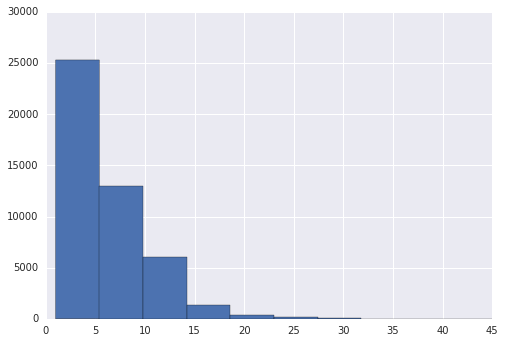

In [362]:
plt.hist(n1lengthList)
plt.show()

In [383]:
def gen_dinucNormDF(seqList):
    nt2=['A','C','G','T']
    A=[0,0,0,0]
    C=[0,0,0,0]
    G=[0,0,0,0]
    T=[0,0,0,0]
    dinuc_df=pd.DataFrame({'nt2':nt2,'A': A,'C': C,'G': G,'T': T})
    dinuc_df.set_index('nt2', inplace=True)
    for seq in seqList:
        #print seq
        for n in range(1,len(seq)):
            nt1=seq[n-1]
            nt2=seq[n]
            dinuc=nt1+nt2
            dinuc_df.loc[nt2,nt1]+=1
    #print dinuc_df
    dinuc_norm_df=dinuc_df/dinuc_df.sum()
    
    return dinuc_norm_df

def gen_nt1FreqsDict(seqList):
    nt1freq={'A':0,'C':0,'G':0,'T':0}
    for seq in seqList:
        nt1=seq[0]
        nt1freq[nt1]+=1
    factor=1.0/sum(nt1freq.itervalues())
    nt1NormFreq = {k: v*factor for k, v in nt1freq.iteritems() }

    return nt1NormFreq

        



In [384]:
dinucNormDFDict={}
nt1FreqsDictDict={}

for length in range(1,21):
    df=n1seq_df[n1seq_df['length']==length]
    #print length
    #print len(df)
    seqListForLength=list(df['sequence'])
    dinucNormDF_forLength=gen_dinucNormDF(seqListForLength)
    nt1freqs_forLength=gen_nt1FreqsDict(seqListForLength)
    dinucNormDFDict[length]=dinucNormDF_forLength
    nt1FreqsDictDict[length]=nt1freqs_forLength

Longer20df=n1seq_df[n1seq_df['length']>20]
seqListLonger20=list(Longer20df['sequence'])
dinucNormDF_Longer20=gen_dinucNormDF(seqListLonger20)
nt1freqs_Longer20=gen_nt1FreqsDict(seqListLonger20)
dinucNormDFDict['Longer20']=dinucNormDF_Longer20
nt1FreqsDictDict['Longer20']=nt1freqs_Longer20

    
    
    

In [379]:
dinucNormDFDict

{1:       A   C   G   T
 nt2                
 A   NaN NaN NaN NaN
 C   NaN NaN NaN NaN
 G   NaN NaN NaN NaN
 T   NaN NaN NaN NaN, 2:             A         C         G         T
 nt2                                        
 A    0.308934  0.134637  0.271973  0.232623
 C    0.347686  0.557542  0.213101  0.324374
 G    0.147470  0.089385  0.272803  0.129750
 T    0.195910  0.218436  0.242123  0.313253, 3:             A         C         G         T
 nt2                                        
 A    0.290743  0.151500  0.241840  0.208403
 C    0.301832  0.536399  0.206973  0.339916
 G    0.188525  0.123955  0.313798  0.170588
 T    0.218901  0.188146  0.237389  0.281092, 4:             A         C         G        T
 nt2                                       
 A    0.299911  0.135290  0.241169  0.22397
 C    0.296935  0.554703  0.215591  0.34611
 G    0.205891  0.143868  0.327162  0.16333
 T    0.197263  0.166140  0.216078  0.26659, 5:             A         C         G         T
 nt2      

In [385]:
nt1FreqsDictDict

{1: {'A': 0.2051025512756378,
  'C': 0.3511755877938969,
  'G': 0.15682841420710353,
  'T': 0.28689344672336164},
 2: {'A': 0.18565147881694644,
  'C': 0.3577138289368505,
  'G': 0.24100719424460432,
  'T': 0.21562749800159872},
 3: {'A': 0.17742510699001426,
  'C': 0.35324536376604854,
  'G': 0.25374465049928674,
  'T': 0.21558487874465052},
 4: {'A': 0.1799284375532459,
  'C': 0.3685466007837792,
  'G': 0.23155563128301246,
  'T': 0.21996933037996252},
 5: {'A': 0.18017831225378395,
  'C': 0.3584905660377359,
  'G': 0.2371967654986523,
  'T': 0.2241343562098279},
 6: {'A': 0.17704757233938206,
  'C': 0.3702795487984306,
  'G': 0.23001471309465427,
  'T': 0.2226581657675331},
 7: {'A': 0.17239404352806414,
  'C': 0.39633447880870565,
  'G': 0.22136311569301262,
  'T': 0.20990836197021764},
 8: {'A': 0.182864883169658,
  'C': 0.4033186589908568,
  'G': 0.20860142228242468,
  'T': 0.20521503555706064},
 9: {'A': 0.16735708367854182,
  'C': 0.4304059652029826,
  'G': 0.20298260149130073,

In [391]:
np.log10(10)

1.0

In [392]:
p1=0.1
p2=0.01
p3=0.00005
pt=p1*p2*p3

In [393]:
pt

5.0000000000000004e-08

In [394]:
np.log10(pt)

-7.3010299956639813

In [395]:
np.log10(p1)+np.log10(p2)+np.log10(p3)

-7.3010299956639813

In [402]:
def calc_ins1Seq_prob(seq):
    length=len(seq)
    nt1=seq[0]
    nt1prob=nt1FreqsDictDict[length][nt1]
    lognt1prob=np.log10(nt1prob)
    logProbSeq=lognt1prob
    for n in range(1,len(seq)):
        nt=seq[n]
        nt_1=seq[n-1]
        depProbNt=dinucNormDFDict[length].loc[nt,nt_1]
        logDepProbNT=np.log10(depProbNt)
        logProbSeq=logProbSeq+logDepProbNT
        
    return logProbSeq

In [403]:
logProbSeq=calc_ins1Seq_prob('AGGAAGTCT')
logProbSeq

-5.4820364730583675

In [405]:
logProbSeq=calc_ins1Seq_prob('AGAGTTTTTTTTTT')
logProbSeq

-8.4133334287985377

In [399]:
nt='A'
nt_1='T'
length=9
dinucNormDFDict[length].loc[nt,nt_1]


0.21625806451612903

In [406]:
frequentSeq='TCGGCCCAAAAGAACCCGACAGCTTTCTATCTCTGTGCCAGTAGTATCTCCGATAGCCCCCCCACAGATACGCAGTATTTTGGCCCA'
moderateSeq='CAGAGCTTGGGGACTCGGCCATGTATCTCTGTGCCAGCAGCGGCCGGCAGGGGTGGGGATAGCAATCAGCCCCAGCATTTTGGTGAT'
rareSeq='CTGACAGTGACCAGTGCCCATCCTGAAGACAGCAGCTTCTACATCTGCAGTGCTAGAAACAACGGGCCGGAGCAGTACTTCGGGCCA'

In [407]:
freqIns=frequentSeq[47:53]
moderateIns=moderateSeq[41:47]
rareIns=rareSeq[57:63]

In [409]:
calc_ins1Seq_prob(freqIns)

-3.3165747331280491

In [410]:
calc_ins1Seq_prob(moderateIns)

-3.3093396267995501

In [411]:
calc_ins1Seq_prob(rareIns)

-3.7535760875800186

# check dependencies:

### dependcies to check:
V-J
D-J
delV/V
delJ/J
del5’D/D
del3’D/D
insVD/insDJ

specific nt freq / specific ins length
compare specific nt freq in insVD to insDJ


In [20]:
p=0.3423423423
p="{:10.4f}".format(p)
print float(p)/3

0.1141


In [50]:
def calc_sig_corr_all2all(df, corr_method, n_per):
    from scipy.stats import pearsonr,spearmanr

    ## stage 1: calculate real correlations and generate dataframe
    print 'calculating real correlations...'
    corr_list=[]
    for n1, column1 in enumerate(list(df.columns.values)):  
        for n2, column2 in enumerate(list(df.columns.values)[n1+2:]):
            if (df[column1].dtype == np.float64 or df[column1].dtype == np.int64)&(df[column2].dtype == np.float64 or df[column2].dtype == np.int64) :
                nc1=np.isnan(df[column1])
                nc2=np.isnan(df[column2])
                n=nc1|nc2
                newx=list(df[column1][~n])
                newy=list(df[column2][~n])
                if corr_method=='pearson':
                    r,p = pearsonr(newx,newy)
                if corr_method=='spearman':
                    r,p = spearmanr(newx,newy)
            else:
                r=np.nan
                p=np.nan
            p=float("{:10.6f}".format(p))
            corr_list.append({'column1':column1,'column2':column2, 'real_r':r, 'real_p':p})         
            
    print 'finished calculating real correlations'
    res_corr_df=pd.DataFrame(corr_list)
    res_corr_df['abs_r'] = res_corr_df['real_r'].abs()
    res_corr_df.sort_index(by=['real_p','abs_r','column1','column2'], ascending=[True,False,True,True],inplace=1)
    res_corr_df.drop('abs_r', axis=1,inplace=1)


## stage 2: permutate result df and calculate correlations over permutated data:
    print 'calculating suffle correlations...'
    for i in range(n_per):
        print i
        print 'start shuffling df'
        shuffle=df.apply(np.random.permutation)
        shuf_corr_list=[]
        #column_list=[]
        for n1, column1 in enumerate(list(shuffle.columns.values)):
            for n2, column2 in enumerate(list(shuffle.columns.values)[n1+2:]):
                if (shuffle[column1].dtype == np.float64 or shuffle[column1].dtype == np.int64)&(shuffle[column2].dtype == np.float64 or shuffle[column2].dtype == np.int64):
                    nc1=np.isnan(shuffle[column1])
                    nc2=np.isnan(shuffle[column2])
                    n=nc1|nc2
                    newx=list(shuffle[column1][~n])
                    newy=list(shuffle[column2][~n])
                    r,p = pearsonr(newx,newy)
                    shuf_corr_list.append(r)
                else:
                    shuf_corr_list.append(np.nan)
            
        res_corr_df.loc[:,('r_shuf_%s'%i)] = shuf_corr_list
    
    print 'finished calculating suffle correlations'
    
    ## stage 3: calculate confidence interval for shuffled r's:
    print 'calculating percentile values...'
    #print shuffle_r_df.columns.values
    col_for_percentile=[col for col in res_corr_df.columns.values if col.startswith('r_shuf_')]
    #shuffle_r_df.loc[:,'r_mean']=np.mean(shuffle_r_df[col_for_percentile])
    #res_corr_df['avg'] = res_corr_df[col_for_percentile].mean(axis=1)
    res_corr_df['r_perc_2_5'] = res_corr_df[col_for_percentile].quantile(q=0.025,axis=1)
    res_corr_df['r_perc_97_5'] = res_corr_df[col_for_percentile].quantile(q=0.975,axis=1)
    print 'finished calculating percentile values'
    
    ## stage 4: check significance of the correlations:
    n_tests=sigma(len(df.columns.values))
    res_correct_p=0.05/n_tests
    res_corr_df['real_p_sig']=np.where(res_corr_df['real_p']<0.05,1,0)
    res_corr_df['real_p_sig_corrected']=np.where(res_corr_df['real_p']<res_correct_p,1,0)
    res_corr_df['r_outof_CI']=np.where((res_corr_df['real_r']<res_corr_df['r_perc_2_5']) | (res_corr_df['real_r']>res_corr_df['r_perc_97_5']) ,1,0)
    col_to_keep=['column1','column2','real_p','real_r','r_perc_2_5','r_perc_97_5','real_p_sig','real_p_sig_corrected','r_outof_CI']
    res_corr_df=res_corr_df[col_to_keep]
    res_corr_df.set_index('column1',inplace=1)
    res_corr_df=res_corr_df[~np.isnan(res_corr_df['real_r'])]
    only_sig_corr_df=res_corr_df[(res_corr_df['real_p_sig']==1) & (res_corr_df['r_outof_CI']==1)]
    
    return res_corr_df,only_sig_corr_df


def sigma(x):
    sigma=0
    for n in range(x):
        sigma=+n
    return sigma


In [75]:
sample_df_non_prod.head()

,nucleotide,aminoAcid,count (reads),frequencyCount (%),cdr3Length,vMaxResolved,vFamilyName,vGeneName,vGeneAllele,vFamilyTies,...,estimatedNumberGenomes,sequenceStatus,cloneResolved,vOrphon,dOrphon,jOrphon,vFunction,dFunction,jFunction,fractionNucleated
0,GTTGGAGTCGGCTGCTCCCTCCCAAACATCTGTGTACTTCTGTGCC...,NaN,192004,2.002389,41,TCRBV06,TCRBV06,unresolved,NaN,NaN,...,5545,Out,VDJ,NaN,NaN,NaN,NaN,NaN,NaN,0.050536
6,AGTCTGCTGCCTCCTCCCAGACATCTGTATATTTCTGCGCCAGCTA...,NaN,33274,0.347011,46,TCRBV10-01,TCRBV10,TCRBV10-01,NaN,NaN,...,960,Out,VDJ,NaN,NaN,NaN,NaN,NaN,NaN,0.008758
7,GTCTGCTGCCTCCTCCCAGACATCTGTATATTTCTGCGCCAGCAGT...,NaN,31146,0.324818,47,TCRBV10-01,TCRBV10,TCRBV10-01,NaN,NaN,...,900,Out,VDJ,NaN,NaN,NaN,NaN,NaN,NaN,0.008198
9,CCTGATCCTGGAGTCGCCCAGCCCCAACCAGACCTCTCTGTACTTC...,NaN,29522,0.307882,35,TCRBV27-01*01,TCRBV27,TCRBV27-01,1.0,NaN,...,852,Out,VDJ,NaN,NaN,NaN,NaN,NaN,NaN,0.007770
12,CGCCCAGCCCCAACCAGACCTCTCTGTACTTCTGTGCCAGCAGACA...,NaN,21619,0.225462,49,TCRBV27-01*01,TCRBV27,TCRBV27-01,1.0,NaN,...,621,Out,VDJ,NaN,NaN,NaN,NaN,NaN,NaN,0.005690


In [12]:
sample_df_non_prod.columns.values

array(['nucleotide', 'aminoAcid', 'count (reads)', 'frequencyCount (%)',
       'cdr3Length', 'vMaxResolved', 'vFamilyName', 'vGeneName',
       'vGeneAllele', 'vFamilyTies', 'vGeneNameTies', 'vGeneAlleleTies',
       'dMaxResolved', 'dFamilyName', 'dGeneName', 'dGeneAllele',
       'dFamilyTies', 'dGeneNameTies', 'dGeneAlleleTies', 'jMaxResolved',
       'jFamilyName', 'jGeneName', 'jGeneAllele', 'jFamilyTies',
       'jGeneNameTies', 'jGeneAlleleTies', 'vDeletion', 'n1Insertion',
       'd5Deletion', 'd3Deletion', 'n2Insertion', 'jDeletion', 'vIndex',
       'n1Index', 'dIndex', 'n2Index', 'jIndex', 'estimatedNumberGenomes',
       'sequenceStatus', 'cloneResolved', 'vOrphon', 'dOrphon', 'jOrphon',
       'vFunction', 'dFunction', 'jFunction', 'fractionNucleated'], dtype=object)

In [77]:
columns_to_keep=['count (reads)', 'frequencyCount (%)',
       'cdr3Length', 'vDeletion', 'n1Insertion',
       'd5Deletion', 'd3Deletion', 'n2Insertion', 'jDeletion', 'estimatedNumberGenomes']

In [78]:
sample_df_non_prod_short=sample_df_non_prod[columns_to_keep]

In [ ]:
res_corr_df,only_sig_corr_df =calc_sig_corr_all2all(sample_df_non_prod_short, 100)

In [ ]:
HIP00602lengthCorrPearson,HIP00602lengthCorrPearsonOnlySig =calc_sig_corr_all2all(sample_df_non_prod_short, 'spearman', 100)

In [27]:
#sample HIP13939:
res_corr_df

,column2,real_p,real_r,r_perc_2_5,r_perc_97_5,real_p_sig,real_p_sig_corrected,r_outof_CI
column1,,,,,,,,
count (reads),estimatedNumberGenomes,0.000000,0.987788,-0.009252,0.008625,1,1,1
frequencyCount (%),estimatedNumberGenomes,0.000000,0.987788,-0.007504,0.008492,1,1,1
cdr3Length,n1Insertion,0.000000,0.456980,-0.008006,0.008757,1,1,1
cdr3Length,n2Insertion,0.000000,0.422810,-0.007342,0.008780,1,1,1
cdr3Length,jDeletion,0.000000,-0.300919,-0.008198,0.006786,1,1,1
cdr3Length,d3Deletion,0.000000,-0.153707,-0.006841,0.011832,1,1,1
cdr3Length,d5Deletion,0.000000,-0.135148,-0.008156,0.009216,1,1,1
n1Insertion,n2Insertion,0.000000,-0.082483,-0.002248,0.003520,1,1,1
d3Deletion,jDeletion,0.000000,-0.046208,NaN,NaN,1,1,0


In [28]:
print len(only_sig_corr_df)
print len(only_sig_corr_df)

36
24


In [29]:
excel_writer='/net/mraid08/export/genie/Lab/Personal/ShaniBAF/TCR_demo_data/SuffStat/HIP13939_lengthParamCorrel.xlsx'
only_sig_corr_df.to_excel(excel_writer, sheet_name='Sheet1', na_rep='', float_format=None, columns=None, header=True, index=True, index_label=None, startrow=0, startcol=0, engine=None, merge_cells=True, encoding=None, inf_rep='inf', verbose=True)

In [81]:
print len(HIP00602lengthCorrPearson)
print len(HIP00602lengthCorrPearsonOnlySig)

36
33


In [80]:
HIP00602lengthCorrPearson

,column2,real_p,real_r,r_perc_2_5,r_perc_97_5,real_p_sig,real_p_sig_corrected,r_outof_CI
column1,,,,,,,,
count (reads),estimatedNumberGenomes,0.000000,0.455115,-0.007758,0.008256,1,1,1
frequencyCount (%),estimatedNumberGenomes,0.000000,0.455115,-0.006299,0.009472,1,1,1
cdr3Length,n1Insertion,0.000000,0.425913,-0.006736,0.008494,1,1,1
cdr3Length,n2Insertion,0.000000,0.396430,-0.006744,0.008361,1,1,1
cdr3Length,jDeletion,0.000000,-0.296365,-0.005951,0.008202,1,1,1
cdr3Length,d3Deletion,0.000000,-0.141269,-0.006132,0.008635,1,1,1
cdr3Length,d5Deletion,0.000000,-0.136136,-0.006885,0.008518,1,1,1
n1Insertion,n2Insertion,0.000000,-0.092702,-0.000462,0.001516,1,1,1
count (reads),n2Insertion,0.000000,-0.082221,-0.007027,0.008041,1,1,1


In [68]:
def draw_correlation_scatter(x, y, figsize = (3, 3), xticks=None, yticks=None,\
                             xlim = None, ylim = None, r = None, ms=4, logd = False,\
                             xlab = None, ylab = None, filename = None, title = None,
                             color = "#a0a0a0", grid = True, dpi = 800, xticklabels = None, 
                             contour = False, **figkwargs):
    from scipy.stats import pearsonr
    fig = plt.figure(figsize = figsize, dpi = dpi)
    axB = fig.add_subplot(111)
    if contour:
        print "Contour plot are experimental here"
        axB.hist2d(x,y,bins = 40,norm=LogNorm())
    else:
        axB.plot(x, y, 'o', color = color, ms=ms, **figkwargs)
    if logd:
        axB.set_xscale('log',basex=2)
        axB.set_yscale('log',basey=2)
    if xticks is not None:
        axB.set_xticks(xticks)
        axB.set_xticklabels(xticks)
    if xticklabels is not None:
        axB.set_xticklabels(xticklabels)
    if yticks is not None:
        axB.set_yticks(yticks)
        axB.set_yticklabels(yticks)
    if xlim is not None:
        axB.set_xlim(xlim)
    if ylim is not None:
        axB.set_ylim(ylim)
    if r is not None: 
        if r == 'pearson':
            n=np.isnan(x)
            newx=list(x[~n])
            newy=list(y[~n])
            r,p = pearsonr(newx,newy)
            axB.text(0.01,0.99,"r=%.4f p=%.4f" %(r,p), transform=axB.transAxes, verticalalignment = 'top', ha = 'left',fontsize=14,color='red')
        if r == 'spearman':
            n=np.isnan(x)
            newx=list(x[~n])
            newy=list(y[~n])
            r,p = spearman(newx,newy)
            axB.text(0.01,0.99,"r=%.4f p=%.4f" %(r,p), transform=axB.transAxes, verticalalignment = 'top', ha = 'left',fontsize=14,color='red')
    if xlab is not None:
        axB.set_xlabel(xlab)
    if ylab is not None:
        axB.set_ylabel(ylab)
    if title is not None:
        plt.title(title, fontsize=16)
    if grid:
        axB.grid()
    if filename is not None:
        fig.savefig(filename, bbox_inches='tight', dpi = dpi)
    axB.margins(0.1, 0.1)
    #axB.set_xmargin(0.2); axB.autoscale_view()
    return fig, axB


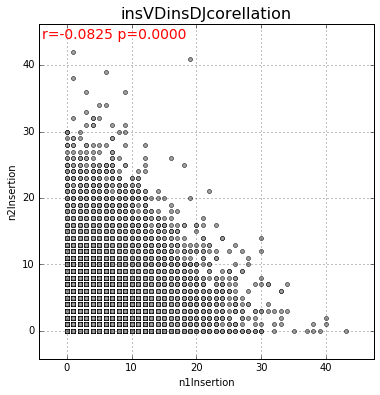

In [70]:
insVDinsDJcorellation=draw_correlation_scatter(sample_df_non_prod_short['n1Insertion'], sample_df_non_prod_short['n2Insertion'],figsize = (6, 6), 
                                           xticks=None, yticks=None, xlim = None, ylim = None, r = 'pearson', ms=4, logd = False,
                                         xlab = 'n1Insertion', ylab = 'n2Insertion', filename = 'insVDinsDJcorellation',
                                           title = 'insVDinsDJcorellation', color = "#a0a0a0", grid = True, dpi = 800, xticklabels = None, contour = False)                                         
plt.show()

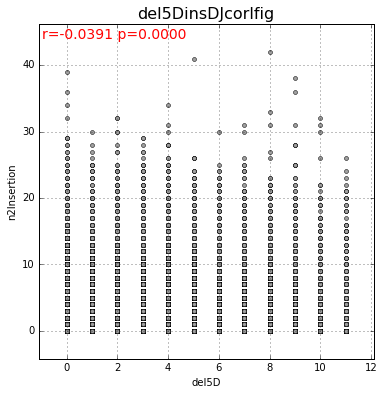

In [59]:
del5DinsDJcorlfig=draw_correlation_scatter(sample_df_non_prod_short['d5Deletion'], sample_df_non_prod_short['n2Insertion'],figsize = (6, 6), 
                                           xticks=None, yticks=None, xlim = None, ylim = None, r = 'pearson', ms=4, logd = False,
                                         xlab = 'del5D', ylab = 'n2Insertion', filename = 'del5DinsDJcorlfig',
                                           title = 'del5DinsDJcorlfig', color = "#a0a0a0", grid = True, dpi = 800, xticklabels = None, contour = False)                                         
plt.show()

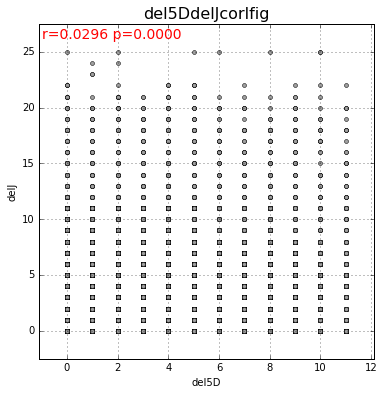

In [60]:
del5DdelJcorlfig=draw_correlation_scatter(sample_df_non_prod_short['d5Deletion'], sample_df_non_prod_short['jDeletion'],figsize = (6, 6), 
                                           xticks=None, yticks=None, xlim = None, ylim = None, r = 'pearson', ms=4, logd = False,
                                         xlab = 'del5D', ylab = 'delJ', filename = 'del5DdelJcorlfig',
                                           title = 'del5DdelJcorlfig', color = "#a0a0a0", grid = True, dpi = 800, xticklabels = None, contour = False)                                         
plt.show()


del5’D-delJ
delV-insVD


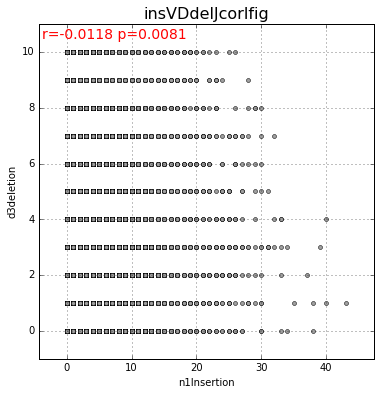

In [48]:
insVDdelJcorlfig=draw_correlation_scatter(sample_df_non_prod_short['n1Insertion'], sample_df_non_prod_short['d3Deletion'],figsize = (6, 6), 
                                           xticks=None, yticks=None, xlim = None, ylim = None, r = True, ms=4, logd = False,
                                         xlab = 'n1Insertion', ylab = 'd3deletion', filename = 'insVDdelJcorlfig',
                                           title = 'insVDdelJcorlfig', color = "#a0a0a0", grid = True, dpi = 800, xticklabels = None, contour = False)                                         
plt.show()

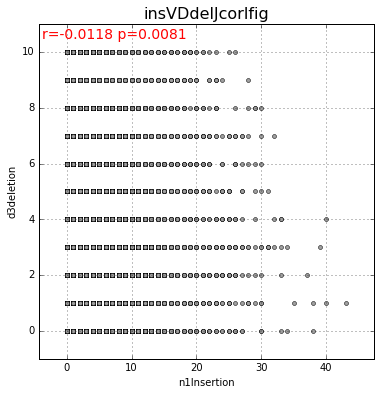

In [48]:
insVDdelJcorlfig=draw_correlation_scatter(sample_df_non_prod_short['n1Insertion'], sample_df_non_prod_short['d3Deletion'],figsize = (6, 6), 
                                           xticks=None, yticks=None, xlim = None, ylim = None, r = True, ms=4, logd = False,
                                         xlab = 'n1Insertion', ylab = 'd3deletion', filename = 'insVDdelJcorlfig',
                                           title = 'insVDdelJcorlfig', color = "#a0a0a0", grid = True, dpi = 800, xticklabels = None, contour = False)                                         
plt.show()

In [53]:
HIP13939lengthCorrSpearman

,column2,real_p,real_r,r_perc_2_5,r_perc_97_5,real_p_sig,real_p_sig_corrected,r_outof_CI
column1,,,,,,,,
count (reads),estimatedNumberGenomes,0.000000,0.475678,-0.007173,0.008349,1,1,1
frequencyCount (%),estimatedNumberGenomes,0.000000,0.475678,-0.006780,0.015234,1,1,1
cdr3Length,n1Insertion,0.000000,0.427934,-0.007048,0.009220,1,1,1
cdr3Length,n2Insertion,0.000000,0.399038,-0.009220,0.007430,1,1,1
cdr3Length,jDeletion,0.000000,-0.276899,-0.007619,0.009933,1,1,1
cdr3Length,d3Deletion,0.000000,-0.138891,-0.007726,0.008553,1,1,1
cdr3Length,d5Deletion,0.000000,-0.134514,-0.006935,0.007256,1,1,1
d3Deletion,jDeletion,0.000000,-0.080674,-0.002329,0.007989,1,1,1
n1Insertion,n2Insertion,0.000000,-0.076888,NaN,NaN,1,1,0


In [54]:
print len(HIP13939lengthCorrSpearman)
print len(HIP13939lengthCorrSpearmanOnlySig)

36
27


##### check weather D and J selections are dependent:

In [373]:
parFreqTable['dFamily']=parFreqTable.index.str[:3]
parFreqTable['jFamily']=parFreqTable.index.str[3:6]
parFreqTable['jGene']=parFreqTable.index.str[3:]
parFreqTable.head()

count (reads)           weighted uniques weighted reads dFamily  \
              n unique sum reads                                           
J-D                                                                        
D01J0101          2113    104081         0.051854       0.072281     D01   
D01J0102          2142     97774         0.052566       0.067901     D01   
D01J0103           703     30806         0.017252       0.021394     D01   
D01J0104           988     50080         0.024246       0.034779     D01   
D01J0105          2307     84099         0.056615       0.058404     D01   

         jFamily  jGene  
                         
J-D                      
D01J0101     J01  J0101  
D01J0102     J01  J0102  
D01J0103     J01  J0103  
D01J0104     J01  J0104  
D01J0105     J01  J0105

In [374]:
#check D frequencies given specific J (based on nUnique:)
feature='n unique'
DgivenJfreq=pd.crosstab(index=parFreqTable.jGene, columns=parFreqTable.dFamily,
                    values=parFreqTable['count (reads)',feature], aggfunc=np.sum, normalize='index')
DgivenJfreq


dFamily,D01,D02
jGene,,
J0101,0.646573,0.353427
J0102,0.662543,0.337457
J0103,0.670162,0.329838
J0104,0.641558,0.358442
J0105,0.674167,0.325833
J0106,0.679477,0.320523
J0201,0.226445,0.773555
J0202,0.349402,0.650598
J0203,0.222142,0.777858


In [ ]:
import seaborn as sns

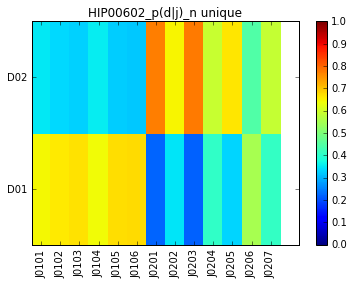

In [375]:
plt.pcolor(DgivenJfreq.T,vmin=0,vmax=1)
#sns.heatmap(DgivenJfreq.T)
plt.colorbar()
cbar.set_ticks([0,1])
cbar.set_ticklabels(['0','1'])
plt.yticks(np.arange(len(DgivenJfreq.columns))+0.5, DgivenJfreq.columns)
#plt.yticks(DgivenJfreq.columns)
plt.xticks(np.arange(len(DgivenJfreq.index))+0.5, DgivenJfreq.index, rotation=90)
plt.title('%s_p(d|j)_%s' %(sample_name, feature))
plt.show()

In [376]:
#check D frequencies given specific J (based on nUnique:)
feature='sum reads'
DgivenJfreq=pd.crosstab(index=parFreqTable.jGene, columns=parFreqTable.dFamily,
                    values=parFreqTable['count (reads)',feature], aggfunc=np.sum, normalize='index')
DgivenJfreq


dFamily,D01,D02
jGene,,
J0101,0.721522,0.278478
J0102,0.703284,0.296716
J0103,0.707290,0.292710
J0104,0.759951,0.240049
J0105,0.567267,0.432733
J0106,0.346956,0.653044
J0201,0.214951,0.785049
J0202,0.343200,0.656800
J0203,0.210904,0.789096


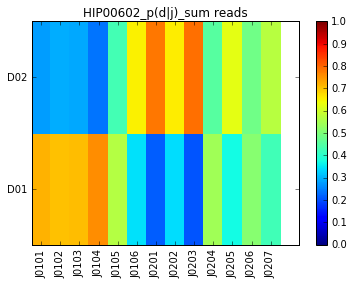

In [377]:
plt.pcolor(DgivenJfreq.T,vmin=0,vmax=1)
#sns.heatmap(DgivenJfreq.T)
plt.colorbar()
cbar.set_ticks([0,1])
cbar.set_ticklabels(['0','1'])
plt.yticks(np.arange(len(DgivenJfreq.columns))+0.5, DgivenJfreq.columns)
#plt.yticks(DgivenJfreq.columns)
plt.xticks(np.arange(len(DgivenJfreq.index))+0.5, DgivenJfreq.index, rotation=90)
plt.title('%s_p(d|j)_%s' %(sample_name, feature))
plt.show()

In [324]:
#check in terms of unique sequences:
DJdepUniqueTable=pd.crosstab(index=parFreqTable.dFamily, columns=parFreqTable.jFamily,
                    values=parFreqTable['count (reads)','n unique'], aggfunc=np.sum)
#, normalize='index')
DJdepUniqueTable=DJdepUniqueTable
DJdepUniqueTable.round(0)

jFamily,J01,J02
dFamily,,
D01,9084,8872
D02,4651,18142


In [325]:
from scipy.stats import fisher_exact
fisher_exact(DJdepUniqueTable)

(3.9938745150940518, 0.0)

In [326]:
#check in terms of reads:
DJdepUniqueTable=pd.crosstab(index=parFreqTable.dFamily, columns=parFreqTable.jFamily,
                    values=parFreqTable['count (reads)','sum reads'], aggfunc=np.sum)
#, normalize='index')
DJdepUniqueTable=DJdepUniqueTable
DJdepUniqueTable.round(0)

jFamily,J01,J02
dFamily,,
D01,389703,288961
D02,217177,544103


In [327]:
from scipy.stats import fisher_exact
fisher_exact(DJdepUniqueTable)

(3.3787947313274707, 0.0)

##### check weather v and j selections are dependent:
(1) calculate j frequencies given D - with two methods (sum reads and n uniques)
(2) visualize using heat maps
(3) calculate chi square - both methods (I used normalized crosstabs)
(4) calculate cramers V (use non normalized crosstabs)

In [ ]:
#check J frequencies given specific D (based on sum reads:)
feature='sum reads'
#feature='n uniques'

if feature=='sum reads':
    aggfunc=np.sum
else:
    aggfunc=np.size

noUnres=sample_df_non_prod[sample_df_non_prod['vGeneName'] !='unresolved']
noUnres=noUnres[sample_df_non_prod['jGeneName'] !='unresolved']
JgivenD=pd.crosstab(index=noUnres.vGeneName, columns=noUnres.jGeneName,
                    values=noUnres['count (reads)'], aggfunc=aggfunc, normalize='index')
JgivenD.head()


In [394]:
print len(JgivenD)

56


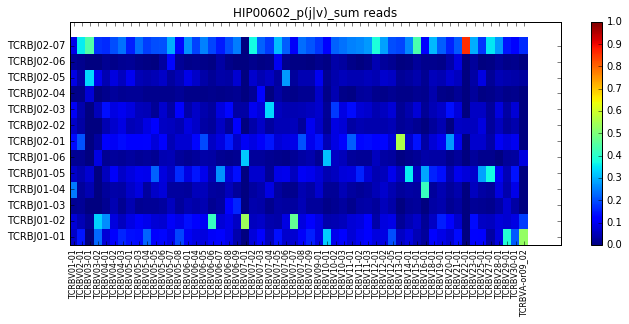

In [399]:
plt.figure(figsize=(11,4))
plt.pcolor(JgivenD.T,vmin=0,vmax=1)
#sns.heatmap(DgivenJfreq.T)
plt.colorbar()
cbar.set_ticks([0,1])
cbar.set_ticklabels(['0','1'])

plt.yticks(np.arange(len(JgivenD.columns))+0.5, JgivenD.columns)
#plt.yticks(DgivenJfreq.columns)
plt.xticks(np.arange(len(JgivenD.index))+0.5, JgivenD.index, rotation=90, fontsize=8)
plt.title('%s_p(j|v)_%s' %(sample_name, feature))


plt.show()

In [ ]:
#check J frequencies given specific D (based on n uniques:)
#feature='sum reads'
feature='n uniques'

if feature=='sum reads':
    aggfunc=np.sum
else:
    aggfunc=np.size

noUnres=sample_df_non_prod[sample_df_non_prod['vGeneName'] !='unresolved']
noUnres=noUnres[sample_df_non_prod['jGeneName'] !='unresolved']
JgivenD=pd.crosstab(index=noUnres.vGeneName, columns=noUnres.jGeneName,
                    values=noUnres['count (reads)'], aggfunc=aggfunc, normalize='index')
JgivenD.head()


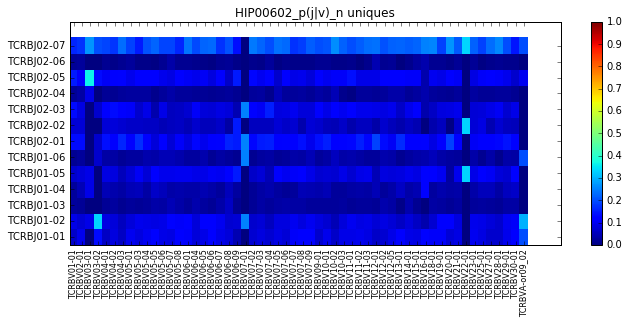

In [401]:
plt.figure(figsize=(11,4))
plt.pcolor(JgivenD.T,vmin=0,vmax=1)
#sns.heatmap(DgivenJfreq.T)
plt.colorbar()
cbar.set_ticks([0,1])
cbar.set_ticklabels(['0','1'])

plt.yticks(np.arange(len(JgivenD.columns))+0.5, JgivenD.columns)
#plt.yticks(DgivenJfreq.columns)
plt.xticks(np.arange(len(JgivenD.index))+0.5, JgivenD.index, rotation=90, fontsize=8)
plt.title('%s_p(j|v)_%s' %(sample_name, feature))


plt.show()

In [517]:
'''
this function generates 'confusion matrix' for chi square test, performs the test, and plot some 
representative data

the input is the sample name and the feature to use (refer to unique sequences only or take into
account the number of reads per sequence)

the data is the fractions of different J's given a specific V. the fraction is converted to integers 
(round percentage, to enable chi sqaure). the 'expected' frequencies are the average frequencies of 
each J across all Vs, so we can detect whether there is a deviation in the pattern of specific V from
general pattern of all Vs.
'''


def ChiSquareJgivenV(sample_name,feature):
    
    #extract data:
    sample_df=pd.read_table("/net/mraid08/export/genie/Lab/Personal/ShaniBAF/TCR_demo_data/%s.tsv" %sample_name)  
    sample_df_non_prod = sample_df[sample_df['sequenceStatus'] != 'In']
        
    
    
    
    #Generate contingency table for chi square test - based on the feature:
    if feature=='sum reads':
        aggfunc=np.sum
    else:
        aggfunc=np.size

    noUnres=sample_df_non_prod[sample_df_non_prod['vGeneName'] !='unresolved']
    noUnres=noUnres[sample_df_non_prod['jGeneName'] !='unresolved']
    JgivenV=pd.crosstab(index=noUnres.vGeneName, columns=noUnres.jGeneName,
                        values=noUnres['count (reads)'], aggfunc=aggfunc, normalize='index')
    JgivenV=JgivenV.fillna(0)
    
    # generate the observed frequencies, which are the mean frequencies for each J segment over all V 
    # segments, converted to integers. 
    observedDF=JgivenV*100
    observedDF=observedDF.round(0)
    observedDF
    
    # convert to integers:
    expected=JgivenV.mean()*100
    expected=expected.round(0)
    expected
    
    # generate dataframe that summarizes the chi square tests comparing the distribution of Js for each specific V
    # with the average frequencies. many Vs show J distributions that deviates from the mean distribution:

    vList=[]
    ChiSqP=[]
    sig=[]
    pCorr=0.05/len(JgivenV.index)
    print pCorr
    for V in JgivenV.index:
        chisq,p=stats.chisquare(f_obs=observedDF.loc[V,:], f_exp=expected)
        vList.append(V)
        ChiSqP.append(p)
        if p<pCorr:
            isSig=1
        else:
            isSig=0
        sig.append(isSig)
    ChiSqJgivenVdf=pd.DataFrame({'V':vList,'p value chi test': ChiSqP, 'is sig (corrected)': sig})
    ChiSqJgivenVdf.sort('p value chi test', inplace=1)
    onlySig=ChiSqJgivenVdf[ChiSqJgivenVdf['is sig (corrected)']==1]
    perSig= float(len(onlySig.index))/len(ChiSqJgivenVdf.index)
        
        
    #plot some of the deviant and non-deviant Vs:
    fig=JgivenV.loc[['TCRBV05-03','TCRBV05-06','TCRBV11-03','TCRBV13-01','TCRBV07-01','TCRBV16-01'],:].T.plot(figsize=(14,4))
    plt.legend(loc='center left', bbox_to_anchor=(1.0, 0.5))
    plt.title ('J frequencies given specific V segments - sample %s - method %s' %(sample_name, feature))
    plt.show()
    return ChiSqJgivenVdf, fig,perSig





/usr/wisdom/python/lib/python2.7/site-packages/ipykernel/__main__.py:31: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/usr/wisdom/python/lib/python2.7/site-packages/ipykernel/__main__.py:65: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)


0.000892857142857


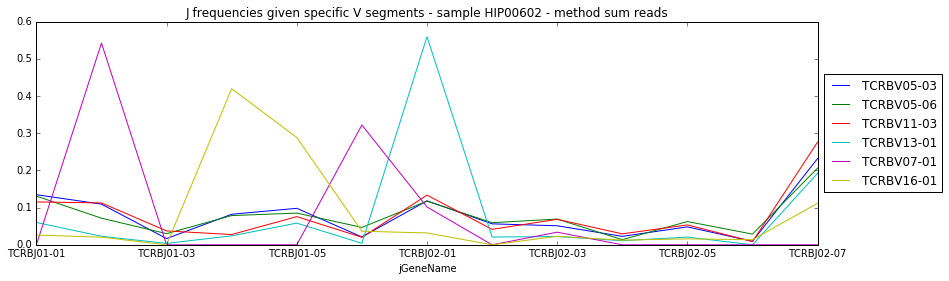

                 V  is sig (corrected)  p value chi test
21      TCRBV07-01                   1      1.871089e-85
43      TCRBV16-01                   1      7.348635e-68
31      TCRBV10-01                   1      2.632843e-49
48      TCRBV22-01                   1      1.041709e-43
2       TCRBV03-01                   1      8.404678e-41
40      TCRBV13-01                   1      1.535415e-39
55  TCRBVA-or09_02                   1      2.942228e-36
27      TCRBV07-07                   1      2.953469e-23
24      TCRBV07-04                   1      7.937419e-22
51      TCRBV27-01                   1      5.125972e-17
17      TCRBV06-06                   1      1.340907e-16
3       TCRBV03-02                   1      1.399184e-15
0       TCRBV01-01                   1      4.119930e-14
26      TCRBV07-06                   1      6.807869e-13
20      TCRBV06-09                   1      6.964268e-13
41      TCRBV14-01                   1      1.303092e-12
53      TCRBV29-01             

In [518]:
ChiSqJgivenVdf_HIP00602_SUMREADS, fig_HIP00602_SUMREADS, perSig =ChiSquareJgivenV('HIP00602','sum reads')
print ChiSqJgivenVdf_HIP00602_SUMREADS
print perSig


/usr/wisdom/python/lib/python2.7/site-packages/ipykernel/__main__.py:31: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/usr/wisdom/python/lib/python2.7/site-packages/ipykernel/__main__.py:65: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)


0.000892857142857


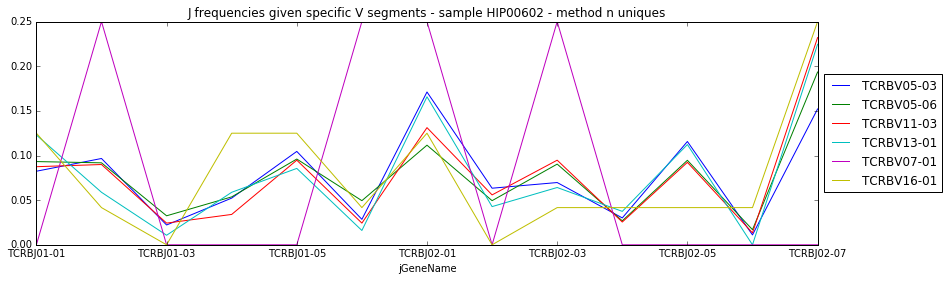

                 V  is sig (corrected)  p value chi test
48      TCRBV22-01                   1      3.990511e-48
21      TCRBV07-01                   1      8.988259e-45
55  TCRBVA-or09_02                   1      9.767981e-29
2       TCRBV03-01                   1      1.290689e-22
3       TCRBV03-02                   1      4.827824e-13
43      TCRBV16-01                   1      1.646058e-06
20      TCRBV06-09                   0      5.390752e-03
37      TCRBV12-01                   0      9.989357e-02
12      TCRBV05-07                   0      1.701477e-01
46      TCRBV20-01                   0      2.232608e-01
40      TCRBV13-01                   0      3.888957e-01
32      TCRBV10-02                   0      4.371137e-01
19      TCRBV06-08                   0      4.901517e-01
24      TCRBV07-04                   0      5.232018e-01
6       TCRBV04-03                   0      6.146250e-01
0       TCRBV01-01                   0      6.407511e-01
10      TCRBV05-05             

In [519]:
ChiSqJgivenVdf_HIP00602_nuniques, fig_HIP00602_nuniques, perSig=ChiSquareJgivenV('HIP00602','n uniques')
print ChiSqJgivenVdf_HIP00602_nuniques
print perSig


In [ ]:
ChiSqJgivenVdf_HIP13939_SUMREADS, fig_HIP13939_SUMREADS, perSig=ChiSquareJgivenV('HIP13939','sum reads')
print ChiSqJgivenVdf_HIP13939_SUMREADS
print perSig


In [ ]:
ChiSqJgivenVdf_HIP13939_nuniques, fig_HIP13939_nuniques, perSig=ChiSquareJgivenV('HIP13939','n uniques')
print ChiSqJgivenVdf_HIP13939_nuniques
print perSig


##### generalize the process above to check dependency of any two categorial variables in our data: 

(1) calculate var2 frequencies given var1 - with two methods (sum reads and n uniques)
(2) visualize using heat maps
(3) calculate chi square - both methods (I used normalized crosstabs)
(4) calculate cramers V (use non normalized crosstabs)

In [291]:
def get_conditional_probs(sample_df_non_prod, feature, var1,var2):
    ## generate contingency tables (normalized and non normalized)
    if feature=='sum reads':
        aggfunc=np.sum
    else:
        aggfunc=np.size

    noUnres=sample_df_non_prod
    if not (noUnres[var1].dtype == np.float64 or noUnres[var1].dtype == np.int64):     
        noUnres=noUnres[sample_df_non_prod[var1] !='unresolved']
    if not (noUnres[var2].dtype == np.float64 or noUnres[var2].dtype == np.int64):     
        noUnres=noUnres[sample_df_non_prod[var2] !='unresolved']
    var1GivenVar2=pd.crosstab(index=noUnres[var2], columns=noUnres[var1],
                        values=noUnres['count (reads)'], aggfunc=aggfunc,normalize='index')
    var1GivenVar2=var1GivenVar2.fillna(0)
    var1GivenVar2notnormalized=pd.crosstab(index=noUnres[var2], columns=noUnres[var1],
                        values=noUnres['count (reads)'], aggfunc=aggfunc)
    var1GivenVar2notnormalized=var1GivenVar2notnormalized.fillna(0)
    #print var1GivenVar2.T.sum() - need to be 1
    
    return var1GivenVar2,var1GivenVar2notnormalized


    
def ChiSquare_conditional_probs(var1GivenVar2,var1GivenVar2notnormalized):
    
    ## generate the observed and expected dfs, and calculate chi square test:
    
    ## the observed are not-normalized contingency table
    ## the expected is generated by using the normalized table--> averaging over var2-->
    ## multiply by the observed sum (in order to generate a table which is similar to the observed in
    ## its fold, but the fractions are the mean fractions)
    ## next we look for values smaller then 5 in both the observed and expected tables, as the chi 
    ## sqaure test assumes there are no such values. we twik the obs and exp tables to the same length
    ## in a way that none include values smaller than 5. 
    
    ## ******currently it is not working very well - everything turns to be significant. need to think of another 
    ## ****** way to twik the lists, or to calculated the expected. I tried also using stats.chi2_contingency which 
    ## ****** calculates the expected by itself and it didn't work!!! 
    
    vList=[]
    ChiSqP=[]
    sig=[]
    observed_len_list=[]
    pCorr=0.05/len(var1GivenVar2.index)
    print('correct p is %s' %pCorr)
    
    max_obs_list=[]
    meanFrac=var1GivenVar2.mean()
    meanSTD=var1GivenVar2.mean()
    for n, value in enumerate(var1GivenVar2.index):
        observed=var1GivenVar2notnormalized.loc[value,:]
        expected=var1GivenVar2.mean()
        expected=expected.round(0)
        
        
        
        max_obs=len(observed)
        max_exp=len(expected)
        for i in range(len(observed)):
            if observed[i]<5:
                max_obs=i
                break


        for j in range(len(expected)):
            if expected[j]<5:
                max_exp=j
                break

        max_obs_list.append(max_obs)
        lim1=min(max_obs,max_exp)
        lim2=max(lim1,5)


        observed=observed[:lim2]
        expected=expected[:lim2]



        chisq,p=stats.chisquare(f_obs=observed, f_exp=expected)       
        vList.append(value)
        ChiSqP.append(p)
        # observed_len_list.append(len(observed)) - delete???
        if p<pCorr:
            isSig=1
        else:
            isSig=0
        sig.append(isSig)
    ChiSqvar1GivenVar2=pd.DataFrame({'%s value' %var2:vList,'p value chi test': ChiSqP, 'is sig (corrected)': sig,
                                     'list length': max_obs_list})
    ChiSqvar1GivenVar2.sort_values('p value chi test', inplace=True)
    ChiSqvar1GivenVar2.set_index('%s value' %var2,inplace=True)
    onlySig=ChiSqvar1GivenVar2[ChiSqvar1GivenVar2['is sig (corrected)']==1]
    perSig= float(len(onlySig.index))/len( ChiSqvar1GivenVar2)
    
    return ChiSqvar1GivenVar2,max_obs_list
    
    
def CramerVStat(max_obs_list,var1GivenVar2notnormalized,n_permut):
    
    ##I'm not sure what is the significance of this cramer tests, the results of the shuffling is very confusing

    ##calculate cramer V statistic for the association strength:
    total_max_obs=max(max_obs_list)
    total_max_obs_final=min(total_max_obs,10)
    confusion_matrix=var1GivenVar2notnormalized.iloc[:total_max_obs_final,:total_max_obs_final]
    #print ('confusion matrix:')
    #print confusion_matrix
    realCramerV=calc_cramer(confusion_matrix)
    CramerVdf=pd.DataFrame({'real Cramer Value': realCramerV})
    
    for n in range(n_permut):
        shuffle_confusion_matrix=confusion_matrix.apply(np.random.permutation)
        ShuffleCramerV=calc_cramer(shuffle_confusion_matrix)
        CramerVdf['permut Cramer Value %s' %n]=ShuffleCramerV
        #print ('shuffle confusion table number %s:' %n)
        #print shuffle_confusion_matrix
        
    return CramerVdf
        
        
    
def calc_cramer(confusion_matrix):
    chi2 = stats.chi2_contingency(confusion_matrix)[0]
    n = confusion_matrix.sum()
    CramerVTable=np.sqrt(chi2 / (n*(min(confusion_matrix.shape)-1))) 
    return CramerVTable



    
    
        
    
def gen_heatmap_conditional_probs(var1GivenVar2, var1,var2): 
    var1GivenVar2WithMeans=var1GivenVar2
    var1GivenVar2WithMeans.loc['mean'] = var1GivenVar2WithMeans.mean()
    
    cmap=plt.get_cmap('jet')
    fig=plt.pcolor(var1GivenVar2WithMeans.T,vmin=0,vmax=1,cmap=cmap)
    plt.colorbar()
    
    
    #cbar=plt.colorbar()
    #cbar.set_ticks([0,1])
    #cbar.set_ticklabels(['0','1'])
    
    
    #plt.xticks(np.arange(var1GivenVar2.shape[0])+0.5, minor=False, var1GivenVar2.index,rotation=90, fontsize=7,va='top')
    #plt.yticks(np.arange(var1GivenVar2.shape[1])+0.5, minor=False, var1GivenVar2.columns)     
    plt.xticks(np.arange(len(var1GivenVar2.index))+0.5, var1GivenVar2.index,rotation=90, fontsize=6,va='top')
    plt.yticks(np.arange(len(var1GivenVar2.columns))+0.5, var1GivenVar2.columns, fontsize=6) 
    plt.ylim(0, len(var1GivenVar2.columns))
    plt.xlim(0, len(var1GivenVar2.index))
    plt.xlabel('%s' %var2)
    plt.ylabel('%s' %var1)
    #plt.title('%s_p(%s|%s)_%s' %(sample_name, var1, var2, feature))

    return fig






In [275]:
sample_name='HIP13939'
feature='sum reads'
var1='jGeneName'
var2='vGeneName'
var1GivenVar2,var1GivenVar2notnormalized,ChiSqvar1GivenVar2,max_obs_list, CramerVTable,fig=check_dependency(sample_name,feature,var1,var2)

Independent variable: vGeneName
Dependent variable: jGeneName
Method used: sum reads
Sample: HIP13939


/usr/wisdom/python/lib/python2.7/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':


correct p is 0.000877192982456


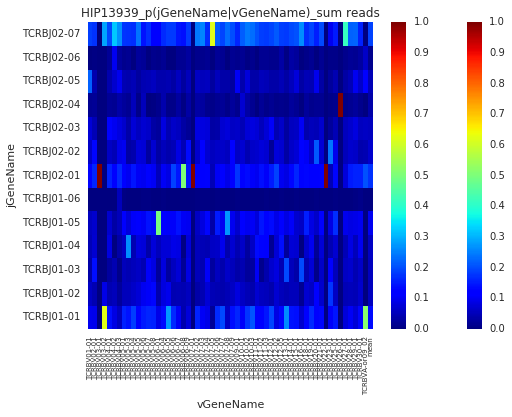

In [276]:
fig=gen_heatmap_conditional_probs(var1GivenVar2, var1,var2)
plt.show()

/usr/wisdom/python/lib/python2.7/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':


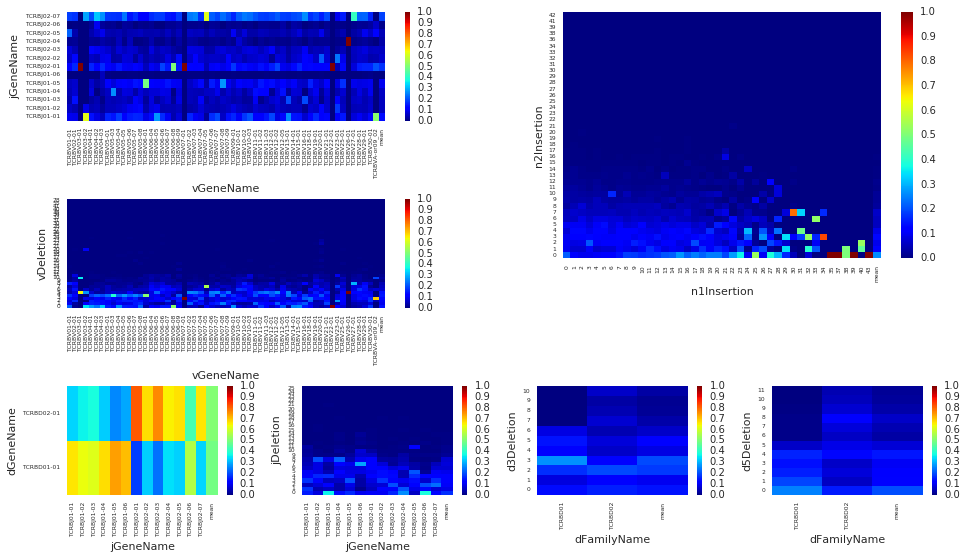

In [300]:
'''
['vGeneName','jGeneName','dGeneName','cdr3Length', 'vDeletion', 'n1Insertion', 'd5Deletion',
            'd3Deletion', 'n2Insertion', 'jDeletion']
'''
sample_name='HIP13939'
feature='sum reads'

fig=plt.figure(figsize = (16,12))

var1='jGeneName'
var2='vGeneName'
var1GivenVar2,var1GivenVar2notnormalized=get_conditional_probs(sample_df_non_prod, feature, var1,var2)
plt.subplot(4,2,1)
fig1=gen_heatmap_conditional_probs(var1GivenVar2, var1,var2)

var1='dGeneName'
var2='jGeneName'
var1GivenVar2,var1GivenVar2notnormalized=get_conditional_probs(sample_df_non_prod, feature, var1,var2)
plt.subplot(4,4,9)
fig1=gen_heatmap_conditional_probs(var1GivenVar2, var1,var2)

var1='n2Insertion'
var2='n1Insertion'
var1GivenVar2,var1GivenVar2notnormalized=get_conditional_probs(sample_df_non_prod, feature, var1,var2)
plt.subplot(2,2,2)
fig1=gen_heatmap_conditional_probs(var1GivenVar2, var1,var2)

var1='vDeletion'
var2='vGeneName'
var1GivenVar2,var1GivenVar2notnormalized=get_conditional_probs(sample_df_non_prod, feature, var1,var2)
plt.subplot(4,2,3)
fig1=gen_heatmap_conditional_probs(var1GivenVar2, var1,var2)

var1='d3Deletion'
var2='dFamilyName'
var1GivenVar2,var1GivenVar2notnormalized=get_conditional_probs(sample_df_non_prod, feature, var1,var2)
plt.subplot(4,4,11)
fig1=gen_heatmap_conditional_probs(var1GivenVar2, var1,var2)

var1='d5Deletion'
var2='dFamilyName' 
var1GivenVar2,var1GivenVar2notnormalized=get_conditional_probs(sample_df_non_prod, feature, var1,var2)
plt.subplot(4,4,12)
fig1=gen_heatmap_conditional_probs(var1GivenVar2, var1,var2)

var1='jDeletion'
var2='jGeneName'
var1GivenVar2,var1GivenVar2notnormalized=get_conditional_probs(sample_df_non_prod, feature, var1,var2)
plt.subplot(4,4,10)
fig1=gen_heatmap_conditional_probs(var1GivenVar2, var1,var2)



plt.subplots_adjust(wspace=0.25,hspace=0.72)
filename='/net/mraid08/export/genie/Lab/Personal/ShaniBAF/TCR_demo_data/SuffStat/SuffStat Images/dependencies'
fig.savefig(filename, bbox_inches='tight', dpi = 800)


plt.show()





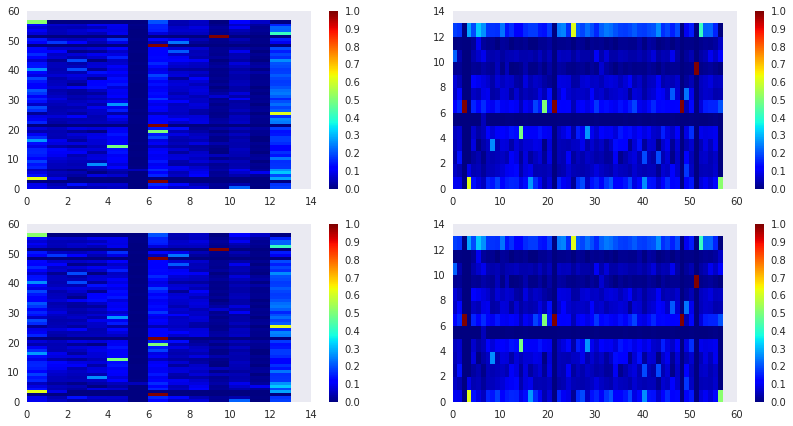

In [256]:
def gen_fig(n,data):
    cmap=plt.get_cmap('jet')
    plt.subplot(2,2,n)
    plt.pcolor(data,vmin=0,vmax=1,cmap=cmap)
    plt.colorbar()

fig=plt.figure(figsize = (14,7))
gen_fig(1,var1GivenVar2)
gen_fig(2,var1GivenVar2.T)
gen_fig(3,var1GivenVar2)
gen_fig(4,var1GivenVar2.T)

plt.show()









In [252]:
fig=plt.figure(figsize=(14,7))

In [183]:
def check_dependency(sample_name,feature,var1,var2):
    
    ## see above comments on the chisquare and cramer v calculations. in general it is not working. nice to use mainly for the 
    ## figures...

    print('Independent variable: %s' %var2)
    print('Dependent variable: %s' %var1)
    print('Method used: %s' %feature)
    print('Sample: %s' %sample_name)
    
    #extract data:
    sample_df=pd.read_table("/net/mraid08/export/genie/Lab/Personal/ShaniBAF/TCR_demo_data/%s.tsv" %sample_name)  
    sample_df_non_prod = sample_df[sample_df['sequenceStatus'] != 'In']
    
    var1GivenVar2,var1GivenVar2notnormalized=get_conditional_probs(sample_df_non_prod, feature, var1,var2)
    ChiSqvar1GivenVar2,max_obs_list=ChiSquare_conditional_probs(var1GivenVar2,var1GivenVar2notnormalized)
    CramerVTable=CramerVStat(max_obs_list,var1GivenVar2notnormalized,10)
    fig=gen_heatmap_conditional_probs(var1GivenVar2, var1,var2)
    
    return var1GivenVar2,var1GivenVar2notnormalized,ChiSqvar1GivenVar2,max_obs_list, CramerVTable,fig
    
    
    
    
    

In [231]:
vList=[]
ChiSqP=[]
sig=[]
observed_len_list=[]
pCorr=0.05/len(var1GivenVar2.index)
print('correct p is %s' %pCorr)

for n, value in enumerate(var1GivenVar2.index):
        observed=var1GivenVar2notnormalized.loc[value,:]
        
        
        meanFrac=var1GivenVar2.mean()
        meanSTD=var1GivenVar2.std()
        CIlower=meanFrac-0.1*meanSTD
        CIupper=meanFrac+0.1*meanSTD
        total=len(var1GivenVar2.columns.values)*len(var1GivenVar2.index)
        meanFracNoOutliersAndSelf=[]
        count=0
        for column in var1GivenVar2.columns.values:
            column_values=[]
            for row in var1GivenVar2.index:
                if (var1GivenVar2.loc[row,column]>CIlower[column] and var1GivenVar2.loc[row,column]<CIupper[column] and 
                   row!=value) :
                    #print column, row, var1GivenVar2.loc[row,column],CIlower[column],CIupper[column]
                    column_values.append(var1GivenVar2.loc[row,column])
                    count=count+1
            columnMeanNoOutliers=np.mean(column_values)
            meanFracNoOutliersAndSelf.append(columnMeanNoOutliers)

        expected=[x*int(var1GivenVar2notnormalized[n:n+1].sum(axis=1)) for x in meanFracNoOutliersAndSelf]
        chisq,p=stats.chisquare(f_obs=observed[:10], f_exp=expected[:10])
        print value
        #print observed[:5]
        #print expected[:5]
        print p
        
        
        
        
        


correct p is 0.000877192982456
TCRBV01-01
3.61414664272e-32
TCRBV02-01
0.0
TCRBV03-01
3.72030356298e-34
TCRBV03-02
6.02805264954e-33
TCRBV04-01
6.9071574772e-280
TCRBV04-02
8.04398059591e-68
TCRBV04-03
0.0
TCRBV05-01
1.92817338561e-261
TCRBV05-03
0.0
TCRBV05-04
7.65846435432e-132
TCRBV05-05
1.61910678311e-38
TCRBV05-06
8.17181848006e-243
TCRBV05-07
5.23438969944e-41
TCRBV05-08
9.52024954635e-182
TCRBV06-01
0.0
TCRBV06-04
0.0
TCRBV06-05
0.0
TCRBV06-06
3.96189263497e-70
TCRBV06-07
2.57186086946e-71
TCRBV06-08
0.0
TCRBV06-09
9.82082521264e-61
TCRBV07-01
0.00103359297228
TCRBV07-02
2.37982486263e-90
TCRBV07-03
3.32692212246e-297
TCRBV07-04
1.21831423602e-89
TCRBV07-05
4.79882276963e-169
TCRBV07-06
1.6946543384e-50
TCRBV07-07
4.76928068672e-54
TCRBV07-08
0.0
TCRBV07-09
1.52684146846e-193
TCRBV09-01
2.78506099701e-100
TCRBV10-01
0.0
TCRBV10-02
1.73536098028e-82
TCRBV10-03
0.0
TCRBV11-01
2.76255249008e-78
TCRBV11-02
3.05770065586e-239
TCRBV11-03
2.8011046807e-274
TCRBV12-01
4.68624520683e-105

In [232]:
vList=[]
ChiSqP=[]
sig=[]
observed_len_list=[]
pCorr=0.05/len(var1GivenVar2.index)
print('correct p is %s' %pCorr)

for n, value in enumerate(var1GivenVar2.index):
        observed=var1GivenVar2notnormalized.loc[value,:]
        
        
        meanFrac=var1GivenVar2.mean()
        meanSTD=var1GivenVar2.std()
        CIlower=meanFrac-0.1*meanSTD
        CIupper=meanFrac+0.1*meanSTD
        total=len(var1GivenVar2.columns.values)*len(var1GivenVar2.index)
        meanFracNoOutliersAndSelf=[]
        count=0
        for column in var1GivenVar2.columns.values:
            column_values=[]
            for row in var1GivenVar2.index:
                if (var1GivenVar2.loc[row,column]>CIlower[column] and var1GivenVar2.loc[row,column]<CIupper[column] and 
                   row!=value) :
                    #print column, row, var1GivenVar2.loc[row,column],CIlower[column],CIupper[column]
                    column_values.append(var1GivenVar2.loc[row,column])
                    count=count+1
            columnMeanNoOutliers=np.mean(column_values)
            meanFracNoOutliersAndSelf.append(columnMeanNoOutliers)

        expected=[x*int(var1GivenVar2notnormalized[n:n+1].sum(axis=1)) for x in meanFracNoOutliersAndSelf]
        from scipy.stats import pearsonr,spearmanr
        r,p = pearsonr(observed,expected)
        print value
        print p
        
        
        


correct p is 0.000877192982456
TCRBV01-01
0.0237225421775
TCRBV02-01
0.000609625326604
TCRBV03-01
0.0856964285757
TCRBV03-02
0.0520302918143
TCRBV04-01
1.4541220883e-05
TCRBV04-02
0.00692873925768
TCRBV04-03
0.0020827346914
TCRBV05-01
3.61794303299e-06
TCRBV05-03
0.0444890925369
TCRBV05-04
3.08317901099e-06
TCRBV05-05
5.318826597e-05
TCRBV05-06
0.000155370016238
TCRBV05-07
0.00025563068837
TCRBV05-08
0.00401274747238
TCRBV06-01
0.252857264066
TCRBV06-04
4.07604373192e-05
TCRBV06-05
0.0019201969209
TCRBV06-06
2.4397188627e-08
TCRBV06-07
2.15675620683e-05
TCRBV06-08
0.0102698662692
TCRBV06-09
0.000272360680678
TCRBV07-01
0.0856964285757
TCRBV07-02
1.39382869067e-05
TCRBV07-03
6.30714727309e-05
TCRBV07-04
0.000154592522423
TCRBV07-05
0.0212526166089
TCRBV07-06
3.18762742994e-05
TCRBV07-07
2.58916837217e-05
TCRBV07-08
0.0131644757242
TCRBV07-09
7.16428106202e-06
TCRBV09-01
1.24624583492e-05
TCRBV10-01
8.68111499062e-06
TCRBV10-02
5.22600681282e-06
TCRBV10-03
3.242381211e-05
TCRBV11-01
0.00

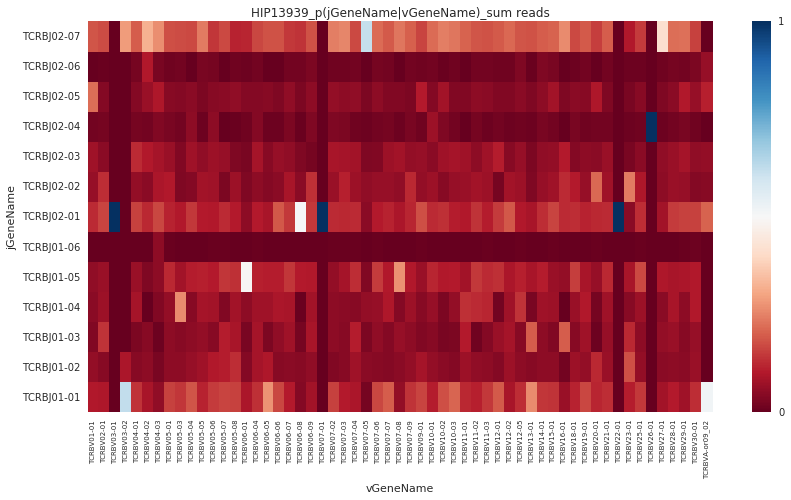

In [185]:
plt.show()

In [157]:
var1GivenVar2.head()

jGeneName,TCRBJ01-01,TCRBJ01-02,TCRBJ01-03,TCRBJ01-04,TCRBJ01-05,TCRBJ01-06,TCRBJ02-01,TCRBJ02-02,TCRBJ02-03,TCRBJ02-04,TCRBJ02-05,TCRBJ02-06,TCRBJ02-07
vGeneName,,,,,,,,,,,,,
TCRBV01-01,0.101171,0.061768,0.036209,0.048633,0.055733,0.002840,0.126731,0.062833,0.076322,0.016329,0.222222,0.003195,0.186013
TCRBV02-01,0.093958,0.043419,0.136977,0.070895,0.069892,0.001354,0.163449,0.130609,0.048834,0.019704,0.041765,0.005766,0.173377
TCRBV03-01,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
TCRBV03-02,0.623377,0.090909,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.285714
TCRBV04-01,0.138701,0.044999,0.029005,0.083130,0.069486,0.002440,0.159574,0.060269,0.128309,0.022590,0.042920,0.021144,0.197434


In [158]:
var1GivenVar2notnormalized.head()

jGeneName,TCRBJ01-01,TCRBJ01-02,TCRBJ01-03,TCRBJ01-04,TCRBJ01-05,TCRBJ01-06,TCRBJ02-01,TCRBJ02-02,TCRBJ02-03,TCRBJ02-04,TCRBJ02-05,TCRBJ02-06,TCRBJ02-07
vGeneName,,,,,,,,,,,,,
TCRBV01-01,285.0,174.0,102.0,137.0,157.0,8.0,357.0,177.0,215.0,46.0,626.0,9.0,524.0
TCRBV02-01,1874.0,866.0,2732.0,1414.0,1394.0,27.0,3260.0,2605.0,974.0,393.0,833.0,115.0,3458.0
TCRBV03-01,0.0,0.0,0.0,0.0,0.0,0.0,39.0,0.0,0.0,0.0,0.0,0.0,0.0
TCRBV03-02,48.0,7.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,22.0
TCRBV04-01,1535.0,498.0,321.0,920.0,769.0,27.0,1766.0,667.0,1420.0,250.0,475.0,234.0,2185.0


In [159]:
## an example for 'bad table':
ChiSqvar1GivenVar2

,is sig (corrected),list length,p value chi test
vGeneName value,,,
TCRBV01-01,1,13,0.000000e+00
TCRBV27-01,1,13,0.000000e+00
TCRBV23-01,1,13,0.000000e+00
TCRBV21-01,1,13,0.000000e+00
TCRBV19-01,1,13,0.000000e+00
TCRBV13-01,1,13,0.000000e+00
TCRBV10-03,1,13,0.000000e+00
TCRBV10-01,1,13,0.000000e+00
TCRBV07-05,1,5,0.000000e+00


In [77]:
## an example for 'bad table':
CramerVTable

vDeletion
0    0.388558
1    0.509951
2    0.439779
3    0.475648
4    0.347525
5    0.631214
6    0.635276
7    0.739930
8    0.810961
9    1.117768
dtype: float64

In [ ]:
f, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, sharex='col', sharey='row')
ax1.plot(x, y)
ax1.set_title('Sharing x per column, y per row')
ax2.scatter(x, y)
ax3.scatter(x, 2 * y ** 2 - 1, color='r')
ax4.plot(x, 2 * y ** 2 - 1, color='r')

In [3]:
with open('/net/mraid08/export/genie/Lab/Personal/ShaniBAF/TCR_demo_data/SuffStat/exp_and_obs_freqs_ins1_dfs/ins1predictionStrengthDF',"rb" ) as f:
    ins1predictionStrengthDF=pickle.load(f)
f.close()

In [4]:
ins1predictionStrengthDF

,# nonProd unique seqeunces,Sample,expected to observed frequency correlation p,expected to observed frequency correlation r,train set fraction
0,8400,HIP13505,1.049509e-07,0.404235,0.8
1,8400,HIP13505,4.995783e-19,0.399624,0.5
2,18148,HIP14071,3.808762e-19,0.471197,0.8
3,18148,HIP14071,1.675009e-43,0.464630,0.5
4,28695,HIP13518,1.672392e-30,0.484092,0.8
5,28695,HIP13518,1.859601e-61,0.463093,0.5
6,48500,HIP01091,1.337372e-59,0.544891,0.8
7,48500,HIP01091,5.324516e-124,0.511947,0.5
8,49988,HIP01197,6.832518e-48,0.487091,0.8
9,49988,HIP01197,3.410554e-102,0.462884,0.5


In [5]:
ins1predictionStrengthDF08=ins1predictionStrengthDF[ins1predictionStrengthDF['train set fraction']==0.8]

In [6]:
ins1predictionStrengthDF05=ins1predictionStrengthDF[ins1predictionStrengthDF['train set fraction']==0.5]

In [8]:
from SufficientStatistics import *

done4


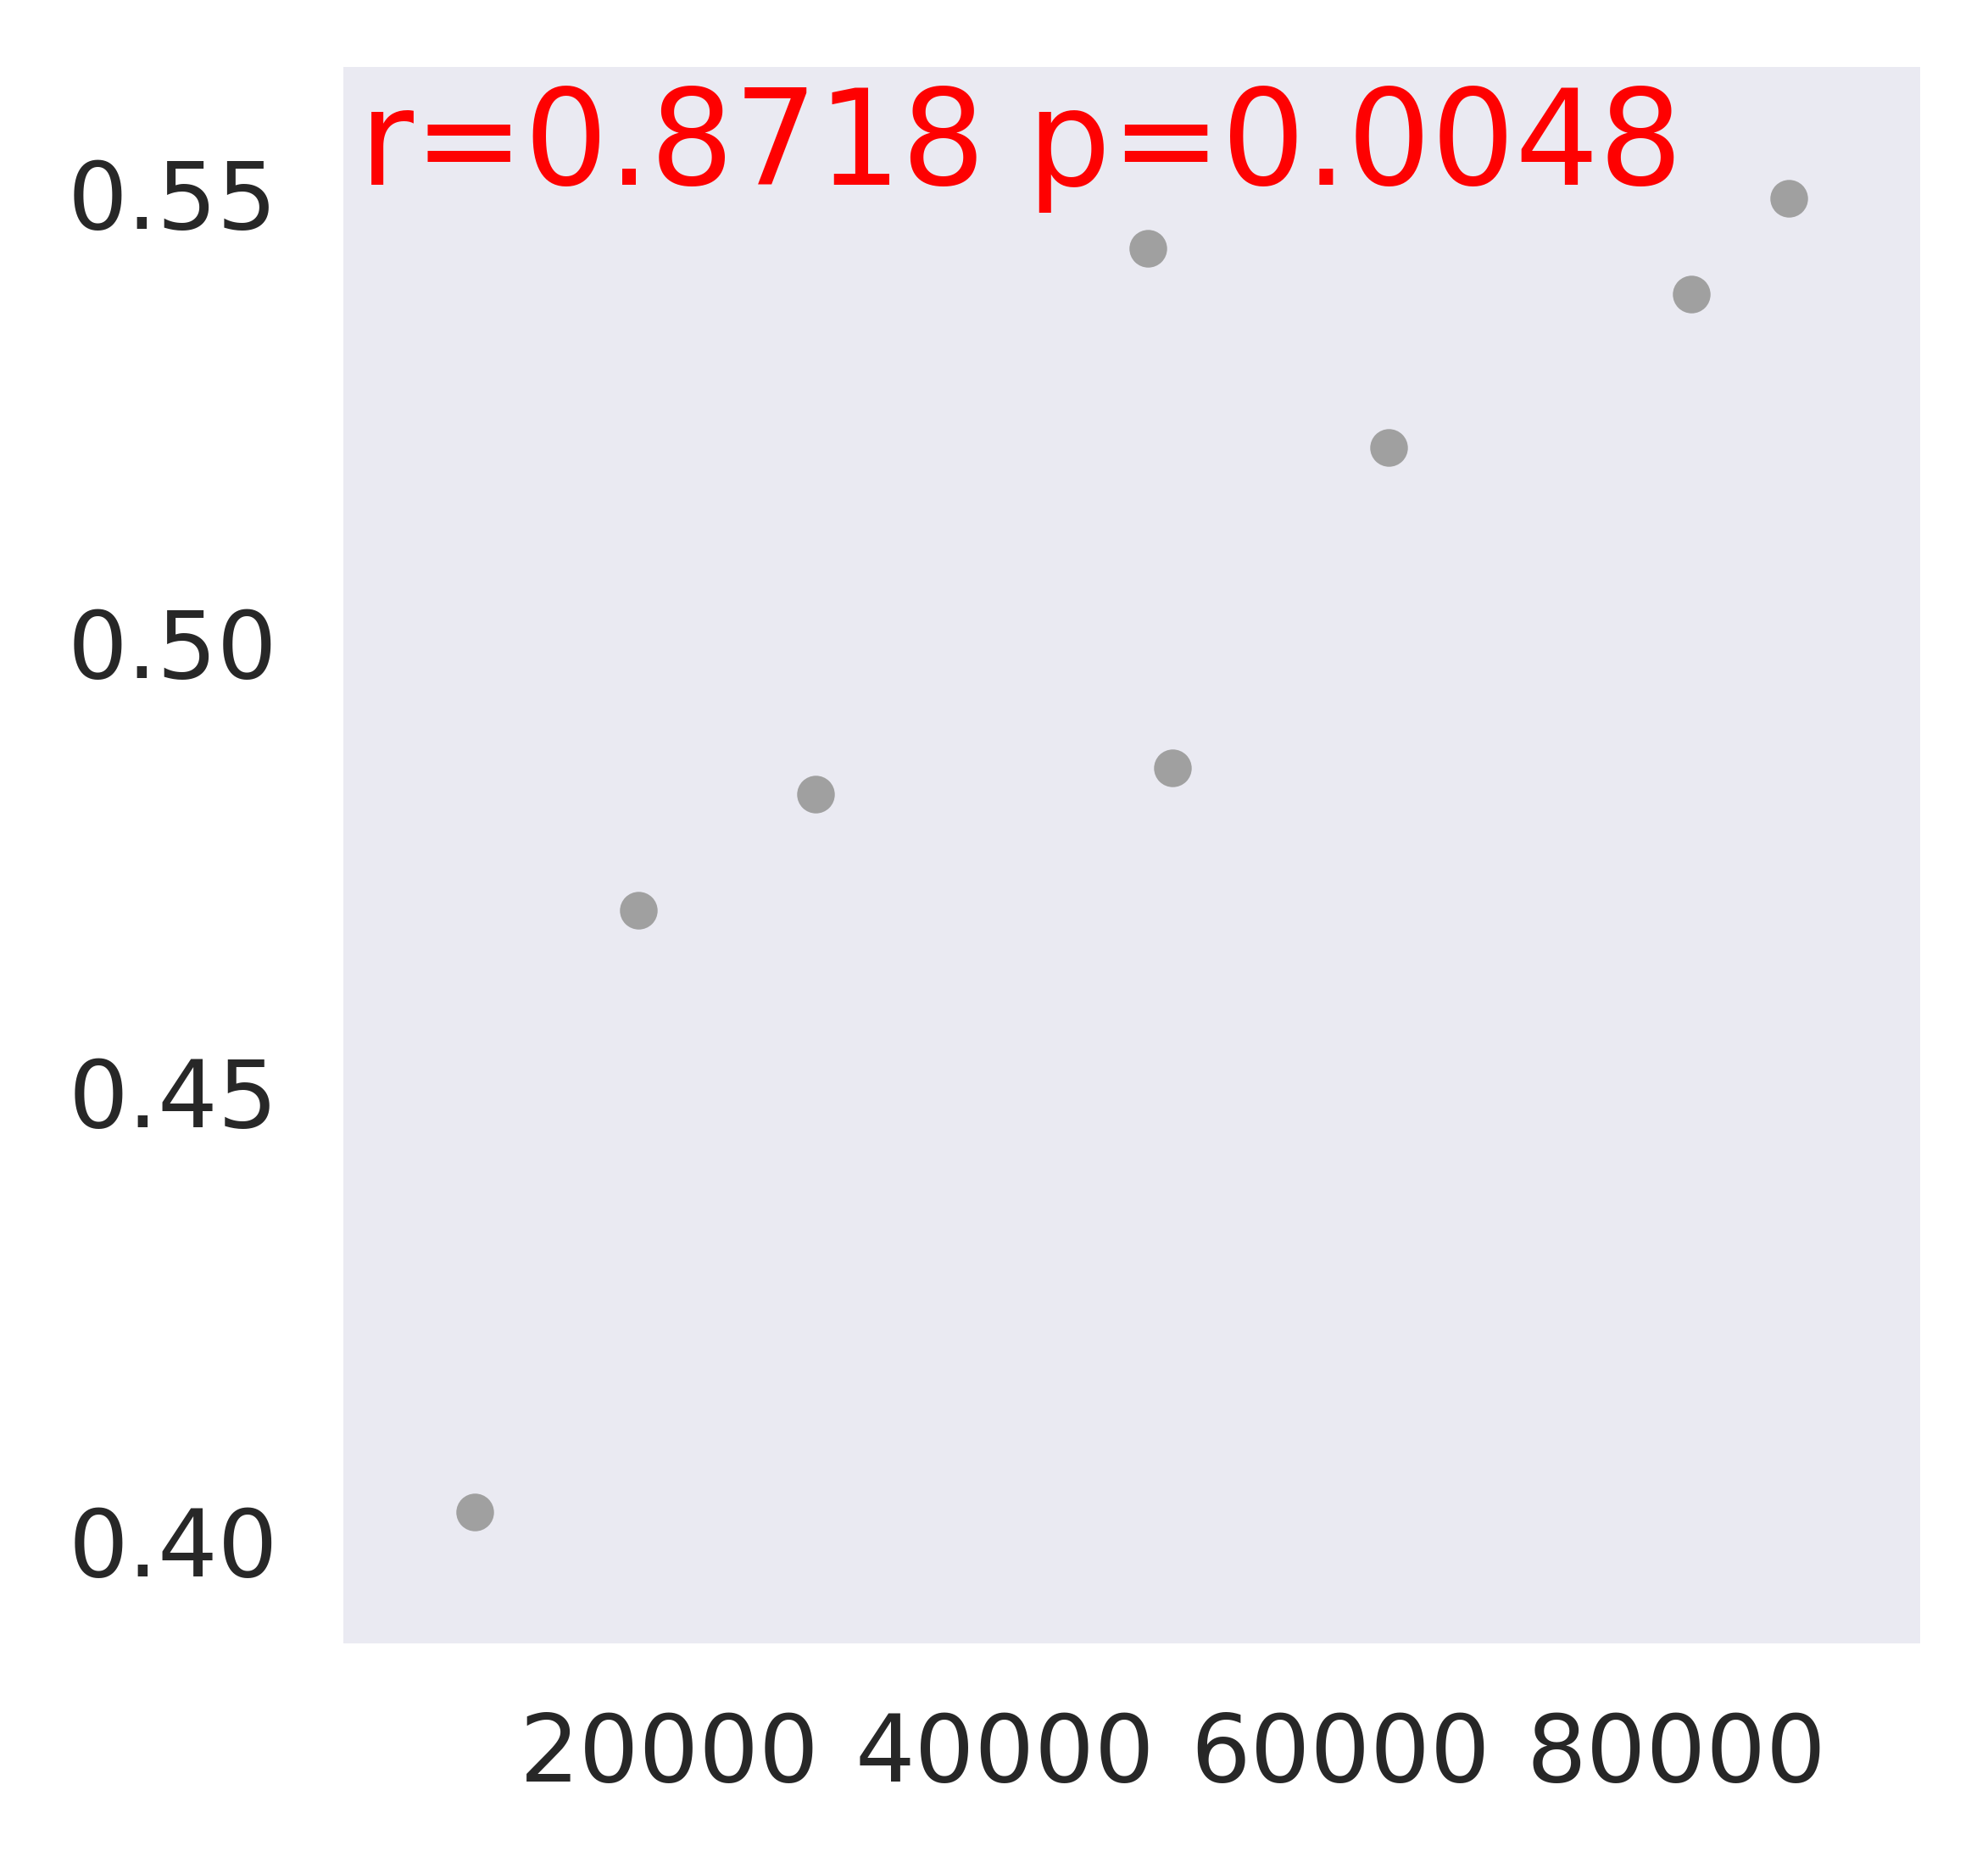

In [15]:
x=ins1predictionStrengthDF08['# nonProd unique seqeunces']
y=ins1predictionStrengthDF08['expected to observed frequency correlation r']




fig, axB,r,p=draw_correlation_scatter(x, y, figsize = (3, 3), xticks=None, yticks=None,\
                             xlim = None, ylim = None, r = 'pearson', ms=4, logd = False,\
                             xlab = None, ylab = None, filename = None, title = None,
                             color = "#a0a0a0", grid = True, dpi = 800, xticklabels = None, 
                             add_identity=None, contour = False, axB=None)
plt.show()

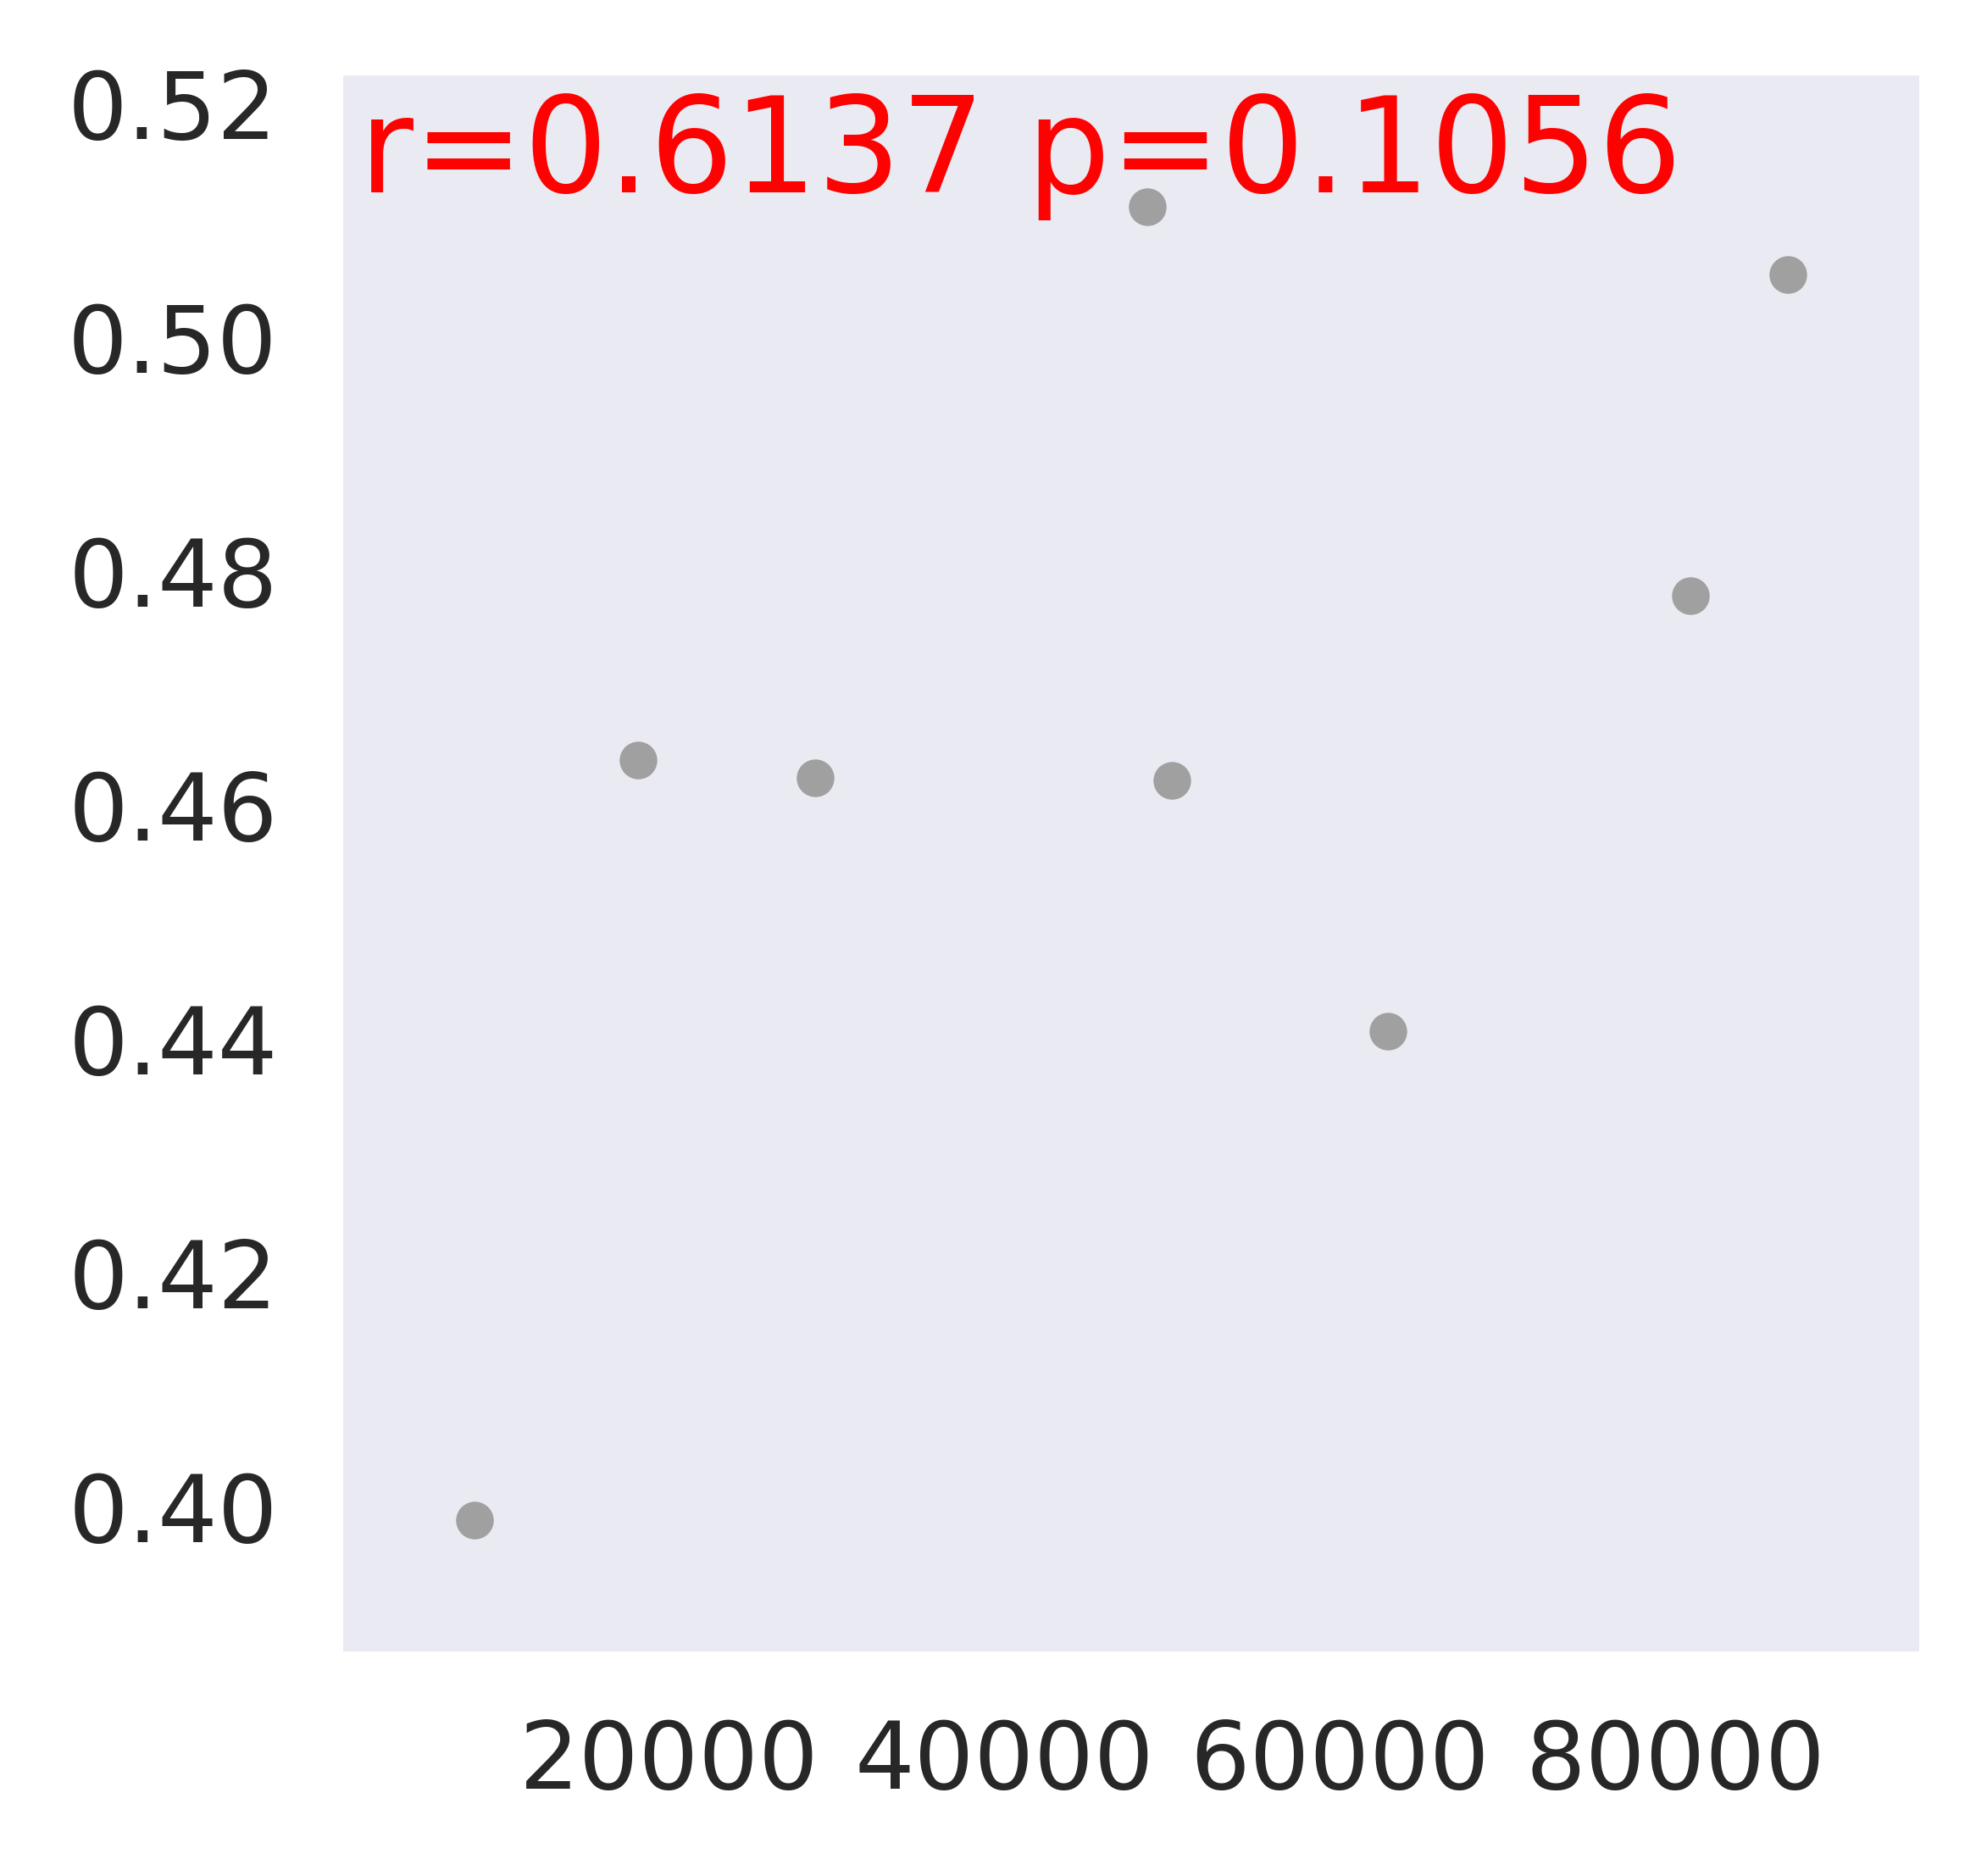

In [16]:
x=ins1predictionStrengthDF05['# nonProd unique seqeunces']
y=ins1predictionStrengthDF05['expected to observed frequency correlation r']




fig, axB,r,p=draw_correlation_scatter(x, y, figsize = (3, 3), xticks=None, yticks=None,\
                             xlim = None, ylim = None, r = 'pearson', ms=4, logd = False,\
                             xlab = None, ylab = None, filename = None, title = None,
                             color = "#a0a0a0", grid = True, dpi = 800, xticklabels = None, 
                             add_identity=None, contour = False, axB=None)
plt.show()